<a href="https://colab.research.google.com/github/mahi97/MahiColabs/blob/master/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

1. random, numpy -> simple random arrauys and numbers
2. torch -> deseing and optimize GNN
3. dgl -> Used to create GNN layers and model
4. ray -> Just used for tuning hyper parameters
5. networkx -> Generate random graphs 
6. matplotlib -> Plot learning curves

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dgl
import dgl.nn as dglnn
  
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import HyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

from networkx.generators.random_graphs import erdos_renyi_graph

import matplotlib.pyplot as plt

Using backend: pytorch


### Easy Plotter Function

In [2]:
def plot_me(x):
  [plt.plot(l) for l in x]
  plt.ylabel('Running Loss')
  plt.show()
  print([l[-1] for l in x])

# Generating Data

### Generate Random Graphs

For any number of nodes and probability of edge existance

In [3]:
def generate_random_graph(num_nodes, prob):
  g = erdos_renyi_graph(num_nodes, prob)
  [g.add_edge(i, i) for i in range(num_nodes)] # add self-loop

  # Generate Adj. Matrix of Graph
  a = torch.zeros(num_nodes, num_nodes)
  for n in g.edges:
    a[n[0]][n[1]] = 1.0
    a[n[1]][n[0]] = 1.0
    a[n[0]][n[0]] = 1.0
    a[n[1]][n[1]] = 1.0

  # Generate dgl object of graph 
  u = list(map(lambda x : x[0], g.edges))
  v = list(map(lambda x : x[1], g.edges))  
  g = dgl.graph((torch.tensor(u), torch.tensor(v)))
  g = dgl.add_self_loop(g)

  return g, a

### Data Loader Function

## Generate data dictionary for training GNN

In [4]:
def data_loader(num_batch):
  w = torch.Tensor([
                  [2.7, 0.0, 1.0],
                  [1.2, 1.3, 0.2],
                  [0.0, 0.5, 0.0],
                  [2.1, 0.0, 1.1],
                  [0.0, 0.0, 0.7]])
  for i in range(num_batch):
    p = random.random()
    g, a =  generate_random_graph(10, p)
    x = torch.rand(10, 5)
    
    yield {
        'feat': x,
        'graph': g,
        'label': torch.matmul(torch.matmul(a, x), w)
        }

# Models

##1. GNN With GraphConv

In [5]:
class GNN(nn.Module):
    def __init__(self, in_feats, hid_feats, hid2_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats=in_feats, 
                                    out_feats=hid_feats) 
                                    # aggregator_type='mean')
        self.conv2 = dglnn.GraphConv(in_feats=hid_feats, 
                                    out_feats=hid2_feats) 
        self.conv3 = dglnn.GraphConv(in_feats=hid2_feats, 
                                    out_feats=out_feats) 
                                    # aggregator_type='mean')
                                    
    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.relu(h)
        h = self.conv3(graph, h)
        return h

## Simple Training Procedure
#### Test Function for evaluationg hyperparamters

In [18]:
def test(config):
  model = GNN(5, config['h1'], config['h2'], 3)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])

  losses = []
  running_loss = 0
  iter = 0
  for i, data in enumerate(data_loader(config['num_batch'])):
    model.train()
    iter += 1
    g = data['graph']
    x = data['feat']
    labels = data['label']
    outputs = model(g, x)
    loss = criterion(outputs, labels)

    loss.backward()
    # optimizer.step()
    running_loss += loss.item()

    # print statistics
    if i % 500 == 499:
        # print("[%5d] loss: %.3f" % (i + 1, running_loss / iter))
        losses.append(running_loss / iter)
        iter = 0
        running_loss = 0.0

    if i % config['batch_size'] == config['batch_size'] - 1:
        optimizer.step()
        optimizer.zero_grad()

  return losses

In [19]:
l = test({
    'h1' : 10,
    'h2' : 10,
    'lr' : 1e-3,
    'momentum' : 0.9,
    'num_batch': 50000,
    'batch_size': 1
})

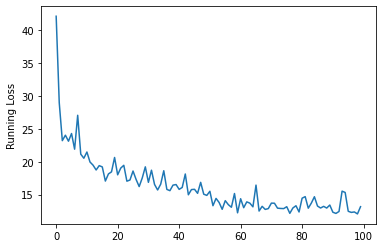

[13.15940514755249]


In [20]:
plot_me([l])

# Tuning of Hyper-Parameters

## Ray Tune Training Function

In [21]:
def train(config):
  model = GNN(5, config['h1'], config['h2'], 3)
  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])


  running_loss = 0
  final = 0
  iter = 0
  for i, data in enumerate(data_loader(config['num_batch'])):
    model.train()
    iter += 1
    g = data['graph']
    x = data['feat']
    labels = data['label']
    outputs = model(g, x)
    loss = criterion(outputs, labels)

    loss.backward()
    # optimizer.step()

    running_loss += loss.item()

    # print statistics
    final = running_loss / iter
    # print statistics
    if i % 5000 == 4999:
        print("[%5d] loss: %.3f" % (i + 1, running_loss / iter))
        iter = 0
        running_loss = 0.0

    if i % config['batch_size'] == config['batch_size'] - 1:
        optimizer.step()
        optimizer.zero_grad()

  tune.report(loss=final)
  print("Finished Training")

## Ray Tune Main Scenario

#### What we tune:

1. Number of neurons in first hidden layer (2^n) [1 < n < 8]
2. Number of neurons in second hidden layer (2^n) [1 < n < 8] 
3. Learning Rate [1e-5 < lr < 1e-1]
4. Momentum of SGD [0.5 < m < 1]
5. Batch Size 10^n [0 < n < 4]


In [22]:
num_batch=50000
num_samples = 100 
config = {
    "h1": tune.sample_from(lambda _: 2 ** np.random.randint(3, 8)),
    "h2": tune.sample_from(lambda _: 2 ** np.random.randint(3, 8)),
    "lr": tune.loguniform(1e-5, 1e-1),
    "num_batch": num_batch,
    "momentum": tune.uniform(0.5, 0.99),
    "batch_size": tune.sample_from(lambda _: 10 ** np.random.randint(0, 4))
}

hyperband = HyperBandScheduler(metric="loss", mode="min")

reporter = CLIReporter(metric_columns=["loss"])

result = tune.run(
    train,
    config=config,
    num_samples=num_samples,
    scheduler=hyperband,
    progress_reporter=reporter
    )

2020-10-18 18:07:36,353	WARNING tune.py:396 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


== Status ==
Memory usage on this node: 5.0/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 4, RUNNING: 1} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 34} 
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {PENDING: 38} 
Resources requested: 1/12 CPUs, 0/1 GPUs, 0.0/6.88 GiB heap, 0.0/2.34 GiB objects (0/1.0 accelerator_type:GTX)
Result logdir: /home/mahi/ray_results/train
Number of trials: 100 (99 PENDING, 1 RUNNING)
+-------------------+----------+-------+--------------+------+------+-------------+------------+
| Trial name        | status   | loc   |   batch_size |   h1 |   h2 |          lr |   momentum |
|-------------------+----------+-------+--------------+------+------+-------------+------------|
| train

(pid=21606) Using backend: pytorch
(pid=21610) Using backend: pytorch
(pid=21594) Using backend: pytorch
(pid=21608) Using backend: pytorch
(pid=21618) Using backend: pytorch
(pid=21592) Using backend: pytorch
(pid=21602) Using backend: pytorch
(pid=21598) Using backend: pytorch
(pid=21620) Using backend: pytorch
(pid=21604) Using backend: pytorch
(pid=21600) Using backend: pytorch
(pid=21624) Using backend: pytorch


(pid=21610) [ 5000] loss: 37.072
(pid=21618) [ 5000] loss: 37.807
(pid=21608) [ 5000] loss: 120.498
(pid=21602) [ 5000] loss: 35.126
(pid=21600) [ 5000] loss: nan
(pid=21606) [ 5000] loss: nan
(pid=21604) [ 5000] loss: 25.466
(pid=21598) [ 5000] loss: 84.631
(pid=21620) [ 5000] loss: nan
(pid=21594) [ 5000] loss: 38.295
(pid=21592) [ 5000] loss: 31.559
(pid=21624) [ 5000] loss: 41.620
(pid=21610) [10000] loss: 17.916
(pid=21602) [10000] loss: 30.491
(pid=21608) [10000] loss: 82.706
(pid=21600) [10000] loss: nan
(pid=21618) [10000] loss: 36.220
(pid=21620) [10000] loss: nan
(pid=21598) [10000] loss: 50.100
(pid=21604) [10000] loss: 12.514
(pid=21594) [10000] loss: 17.212
(pid=21606) [10000] loss: nan
(pid=21592) [10000] loss: 30.470
(pid=21624) [10000] loss: 40.545
(pid=21610) [15000] loss: 14.958
(pid=21602) [15000] loss: 36.074
(pid=21618) [15000] loss: 36.403
(pid=21600) [15000] loss: nan
(pid=21608) [15000] loss: 45.609
(pid=21620) [15000] loss: nan
(pid=21598) [15000] loss: 37.314


(pid=21791) Using backend: pytorch


Result for train_771eb_00007:
  date: 2020-10-18_18-13-48
  done: false
  experiment_id: 7280255dc44b4c0091d5b6bd12886c84
  experiment_tag: 7_batch_size=10,h1=8,h2=16,lr=0.00030912,momentum=0.5543
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.52453355102539
  node_ip: 192.168.1.4
  pid: 21610
  time_since_restore: 370.13042402267456
  time_this_iter_s: 370.13042402267456
  time_total_s: 370.13042402267456
  timestamp: 1603032228
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00007
  
(pid=21610) [50000] loss: 11.525
(pid=21610) Finished Training


(pid=21684) Using backend: pytorch


Result for train_771eb_00003:
  date: 2020-10-18_18-13-51
  done: false
  experiment_id: e9e39a7b2b724bfa85ad97225d1565c9
  experiment_tag: 3_batch_size=10,h1=32,h2=16,lr=1.2771e-05,momentum=0.83398
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 20.023636805009843
  node_ip: 192.168.1.4
  pid: 21598
  time_since_restore: 372.1784291267395
  time_this_iter_s: 372.1784291267395
  time_total_s: 372.1784291267395
  timestamp: 1603032231
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00003
  
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=-0.5%): {RUNNING: 4, TERMINATED: 1} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=-0.3%): {RUNNING: 7, TERMINATED: 1} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 14, RUNNING: 1} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING:

(pid=21746) Using backend: pytorch


Result for train_771eb_00009:
  date: 2020-10-18_18-13-52
  done: false
  experiment_id: 95b0453927f74f829ae150282230995c
  experiment_tag: 9_batch_size=1000,h1=8,h2=64,lr=2.1502e-05,momentum=0.68913
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 22.64038486329317
  node_ip: 192.168.1.4
  pid: 21608
  time_since_restore: 373.84846544265747
  time_this_iter_s: 373.84846544265747
  time_total_s: 373.84846544265747
  timestamp: 1603032232
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00009
  
(pid=21608) [50000] loss: 22.640
(pid=21608) Finished Training


(pid=21721) Using backend: pytorch
(pid=21773) Using backend: pytorch


Result for train_771eb_00010:
  date: 2020-10-18_18-13-56
  done: false
  experiment_id: 8930f7e99ace4e37a2ee90eb90a104bd
  experiment_tag: 10_batch_size=100,h1=128,h2=64,lr=0.072851,momentum=0.72006
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 21600
  time_since_restore: 377.2366769313812
  time_this_iter_s: 377.2366769313812
  time_total_s: 377.2366769313812
  timestamp: 1603032236
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00010
  
(pid=21600) [50000] loss: nan
(pid=21600) Finished Training
== Status ==
Memory usage on this node: 6.7/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=-0.5%): {RUNNING: 3, TERMINATED: 2} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=-1.1%): {RUNNING: 5, TERMINATED: 3} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 11, RUNNING: 4} 
  Bracket(Max Size (n)=

(pid=21700) Using backend: pytorch


Result for train_771eb_00002:
  date: 2020-10-18_18-13-59
  done: false
  experiment_id: 51a8111ebcf242038dd37d183cc4b98d
  experiment_tag: 2_batch_size=10,h1=128,h2=32,lr=0.024102,momentum=0.56594
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 21606
  time_since_restore: 380.4022946357727
  time_this_iter_s: 380.4022946357727
  time_total_s: 380.4022946357727
  timestamp: 1603032239
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00002
  
(pid=21606) [50000] loss: nan
(pid=21606) Finished Training


(pid=21784) Using backend: pytorch
(pid=21733) Using backend: pytorch


Result for train_771eb_00008:
  date: 2020-10-18_18-14-00
  done: false
  experiment_id: 16c21e0d64d540b6bc9c04aa980193ba
  experiment_tag: 8_batch_size=100,h1=128,h2=128,lr=0.0061961,momentum=0.8606
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 21620
  time_since_restore: 381.9387664794922
  time_this_iter_s: 381.9387664794922
  time_total_s: 381.9387664794922
  timestamp: 1603032240
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00008
  
(pid=21620) [50000] loss: nan
(pid=21620) Finished Training


(pid=21671) Using backend: pytorch


Result for train_771eb_00005:
  date: 2020-10-18_18-14-05
  done: false
  experiment_id: 39acfd3855394fa6bcebef7919dec1cf
  experiment_tag: 5_batch_size=1,h1=128,h2=32,lr=0.00062355,momentum=0.59598
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.277377136972547
  node_ip: 192.168.1.4
  pid: 21604
  time_since_restore: 386.8605864048004
  time_this_iter_s: 386.8605864048004
  time_total_s: 386.8605864048004
  timestamp: 1603032245
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00005
  
(pid=21604) [50000] loss: 9.277
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=-1.0%): {RUNNING: 1, TERMINATED: 4} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=-1.6%): {RUNNING: 3, TERMINATED: 5} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 7, RUNNING: 8} 
  Bracket(Max Size (n)=34, Milestone (r)

(pid=21659) Using backend: pytorch


Result for train_771eb_00000:
  date: 2020-10-18_18-14-08
  done: false
  experiment_id: 1bda86e3ad4348d284131f3d95420062
  experiment_tag: 0_batch_size=1,h1=16,h2=64,lr=0.0049229,momentum=0.82045
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.47144813351631
  node_ip: 192.168.1.4
  pid: 21592
  time_since_restore: 389.97425365448
  time_this_iter_s: 389.97425365448
  time_total_s: 389.97425365448
  timestamp: 1603032248
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00000
  
(pid=21592) [50000] loss: 36.471
(pid=21592) Finished Training


(pid=21644) Using backend: pytorch


Result for train_771eb_00011:
  date: 2020-10-18_18-14-10
  done: false
  experiment_id: ec5d231d7b0644c2893a8945578792bd
  experiment_tag: 11_batch_size=1,h1=64,h2=32,lr=0.033307,momentum=0.92484
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 40.009833913826945
  node_ip: 192.168.1.4
  pid: 21624
  time_since_restore: 392.10332679748535
  time_this_iter_s: 392.10332679748535
  time_total_s: 392.10332679748535
  timestamp: 1603032250
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00011
  
(pid=21624) [50000] loss: 40.010
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=-1.9%): {RUNNING: 2, TERMINATED: 6} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 5, RUNNING: 10} 
  Bracket(Max Size (n)=34, Milestone (r)=3, com

(pid=22253) Using backend: pytorch


(pid=21791) [ 5000] loss: nan
(pid=21684) [ 5000] loss: 53.105
(pid=21721) [ 5000] loss: 99.469
(pid=21746) [ 5000] loss: 41.277
(pid=21773) [ 5000] loss: 102.145
(pid=21700) [ 5000] loss: 24226743154992.934
(pid=21784) [ 5000] loss: 105.446
(pid=21733) [ 5000] loss: 52568989192513.531
(pid=21671) [ 5000] loss: 38.962
(pid=21659) [ 5000] loss: 95.369
(pid=21644) [ 5000] loss: nan
(pid=22253) [ 5000] loss: 26.778
(pid=21791) [10000] loss: nan
(pid=21684) [10000] loss: 35.958
(pid=21721) [10000] loss: 57.351
(pid=21773) [10000] loss: 58.361
(pid=21746) [10000] loss: 18.335
(pid=21784) [10000] loss: 37.062
(pid=21700) [10000] loss: nan
(pid=21733) [10000] loss: nan
(pid=21659) [10000] loss: 56.984
(pid=21671) [10000] loss: 38.946
(pid=21644) [10000] loss: nan
(pid=22253) [10000] loss: 13.101
(pid=21791) [15000] loss: nan
(pid=21684) [15000] loss: 35.338
(pid=21721) [15000] loss: 49.064
(pid=21773) [15000] loss: 51.472
(pid=21746) [15000] loss: 13.888
(pid=21784) [15000] loss: 37.048
(pid=

(pid=22356) Using backend: pytorch


Result for train_771eb_00013:
  date: 2020-10-18_18-20-12
  done: false
  experiment_id: 973dce66489340498cc85a69561c2d36
  experiment_tag: 13_batch_size=100,h1=128,h2=128,lr=0.001092,momentum=0.50053
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.478395044374466
  node_ip: 192.168.1.4
  pid: 21684
  time_since_restore: 382.23095059394836
  time_this_iter_s: 382.23095059394836
  time_total_s: 382.23095059394836
  timestamp: 1603032612
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00013
  
== Status ==
Memory usage on this node: 6.6/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=-0.2%): {PENDING: 3, RUNNING: 12} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 34} 
  Bracket(

2020-10-18 18:20:13,477	WARNING worker.py:1072 -- The actor or task with ID ffffffffffffffff5bc74a8d01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 3.000000}, {node:192.168.1.4: 1.000000}, {memory: 6.884766 GiB}, {accelerator_type:GTX: 1.000000}, {GPU: 1.000000}, {object_store_memory: 2.343750 GiB}. In total there are 0 pending tasks and 3 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=21733) 2020-10-18 18:20:13,726	INFO (unknown file):0 -- gc.collect() freed 6 refs in 0.11571639399880951 seconds
(pid=22384) 2020-10-18 18:20:13,692	INFO (unknown file):0 -- gc.collect() freed 15 refs in 0.08380095500069729 seconds
(pid=21746) 202

Result for train_771eb_00018:
  date: 2020-10-18_18-20-15
  done: false
  experiment_id: 4803c45bbd46437f8be5875f50986f13
  experiment_tag: 18_batch_size=100,h1=32,h2=32,lr=0.001384,momentum=0.91117
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.28796542248726
  node_ip: 192.168.1.4
  pid: 21784
  time_since_restore: 376.1563560962677
  time_this_iter_s: 376.1563560962677
  time_total_s: 376.1563560962677
  timestamp: 1603032615
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00018
  
(pid=21784) [50000] loss: 36.288
(pid=21784) Finished Training
Result for train_771eb_00016:
  date: 2020-10-18_18-20-16
  done: false
  experiment_id: 0cbe028699fc4cbb8d87732f1a9fe73b
  experiment_tag: 16_batch_size=10,h1=128,h2=32,lr=1.572e-05,momentum=0.63636
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 24.250969193792344
  node_ip: 192.168.1.4
  pid: 21773
  time_since_restore: 382.0293400287628
  time_this_ite

(pid=22434) Using backend: pytorch
(pid=22419) Using backend: pytorch


Result for train_771eb_00019:
  date: 2020-10-18_18-20-18
  done: false
  experiment_id: 217f8c808a964bd38d0dfe7ebc706360
  experiment_tag: 19_batch_size=1000,h1=32,h2=32,lr=0.00037243,momentum=0.88583
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 21733
  time_since_restore: 378.3405730724335
  time_this_iter_s: 378.3405730724335
  time_total_s: 378.3405730724335
  timestamp: 1603032618
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00019
  
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=-1.4%): {RUNNING: 10, TERMINATED: 5} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 32, RUNNING: 2} 
  Bracket(M

(pid=22426) Using backend: pytorch


Result for train_771eb_00014:
  date: 2020-10-18_18-20-20
  done: false
  experiment_id: 6e932512dc504953b79e259eee8a6a68
  experiment_tag: 14_batch_size=1,h1=128,h2=8,lr=0.00022034,momentum=0.56569
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.056581822574138
  node_ip: 192.168.1.4
  pid: 21746
  time_since_restore: 388.0147912502289
  time_this_iter_s: 388.0147912502289
  time_total_s: 388.0147912502289
  timestamp: 1603032620
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00014
  
(pid=21746) [50000] loss: 11.057
(pid=21746) Finished Training
Result for train_771eb_00021:
  date: 2020-10-18_18-20-21
  done: false
  experiment_id: e293674bd9354ddba7c1ea0c4ce5bbde
  experiment_tag: 21_batch_size=100,h1=16,h2=64,lr=1.2933e-05,momentum=0.74924
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 22.307362987327576
  node_ip: 192.168.1.4
  pid: 21659
  time_since_restore: 374.24225330352783
  time_this_

(pid=22395) Using backend: pytorch
(pid=22398) Using backend: pytorch


Result for train_771eb_00022:
  date: 2020-10-18_18-20-24
  done: false
  experiment_id: fb619d46edac49d8bcfba1ef62094309
  experiment_tag: 22_batch_size=100,h1=128,h2=16,lr=0.079655,momentum=0.92088
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 21644
  time_since_restore: 374.41202569007874
  time_this_iter_s: 374.41202569007874
  time_total_s: 374.41202569007874
  timestamp: 1603032624
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00022
  
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=-2.2%): {RUNNING: 7, TERMINATED: 8} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 29, RUNNING: 5} 
  Bracket(M

(pid=22402) Using backend: pytorch


Result for train_771eb_00023:
  date: 2020-10-18_18-20-38
  done: false
  experiment_id: 8e772d1ad7b34019bd3f12f9ec3044f6
  experiment_tag: 23_batch_size=1,h1=32,h2=32,lr=4.7867e-05,momentum=0.97382
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.330842914760114
  node_ip: 192.168.1.4
  pid: 22253
  time_since_restore: 384.55846095085144
  time_this_iter_s: 384.55846095085144
  time_total_s: 384.55846095085144
  timestamp: 1603032638
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00023
  
(pid=22253) [50000] loss: 9.331
(pid=22253) Finished Training
== Status ==
Memory usage on this node: 6.7/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=-2.4%): {RUNNING: 6, TERMINATED: 9} 
  Bracket(Max Size (n)=34

(pid=22399) Using backend: pytorch


Result for train_771eb_00020:
  date: 2020-10-18_18-20-40
  done: false
  experiment_id: cc6c6d3446554ac29c230644ac90de42
  experiment_tag: 20_batch_size=1,h1=64,h2=128,lr=0.06281,momentum=0.74811
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 38.16943729383946
  node_ip: 192.168.1.4
  pid: 21671
  time_since_restore: 397.7429223060608
  time_this_iter_s: 397.7429223060608
  time_total_s: 397.7429223060608
  timestamp: 1603032640
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00020
  
(pid=21671) [50000] loss: 38.169
(pid=21671) Finished Training


(pid=22400) Using backend: pytorch


(pid=22356) [ 5000] loss: 93.434
(pid=22381) [ 5000] loss: 491401871.359
(pid=22379) [ 5000] loss: 34.936
(pid=22384) [ 5000] loss: 132.163
(pid=22434) [ 5000] loss: 30.306
(pid=22419) [ 5000] loss: 27080986140564653432897536.000
(pid=22426) [ 5000] loss: 58.488
(pid=22395) [ 5000] loss: 106.797
(pid=22398) [ 5000] loss: 35.633
(pid=22402) [ 5000] loss: 35.393
(pid=22399) [ 5000] loss: 37.936
(pid=22400) [ 5000] loss: 117.248
(pid=22356) [10000] loss: 59.350
(pid=22379) [10000] loss: 15.538
(pid=22381) [10000] loss: 3524081021.301
(pid=22384) [10000] loss: 68.205
(pid=22434) [10000] loss: 15.970
(pid=22419) [10000] loss: inf
(pid=22395) [10000] loss: 54.752
(pid=22426) [10000] loss: 29.793
(pid=22398) [10000] loss: 17.444
(pid=22402) [10000] loss: 35.613
(pid=22399) [10000] loss: 37.659
(pid=22400) [10000] loss: 65.504
(pid=22356) [15000] loss: 52.325
(pid=22381) [15000] loss: 951473096.275
(pid=22379) [15000] loss: 12.192
(pid=22384) [15000] loss: 55.406
(pid=22434) [15000] loss: 13.0

(pid=22383) Using backend: pytorch


(pid=22399) [45000] loss: 38.274
Result for train_771eb_00027:
  date: 2020-10-18_18-26-23
  done: false
  experiment_id: 3500f451f6804eac99af6ce2d9be1dcc
  experiment_tag: 27_batch_size=1000,h1=8,h2=64,lr=0.0029063,momentum=0.82182
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 1281171.317959375
  node_ip: 192.168.1.4
  pid: 22381
  time_since_restore: 367.7535824775696
  time_this_iter_s: 367.7535824775696
  time_total_s: 367.7535824775696
  timestamp: 1603032983
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00027
  
(pid=22381) [50000] loss: 1281171.318
(pid=22381) Finished Training


(pid=22731) Using backend: pytorch


Result for train_771eb_00025:
  date: 2020-10-18_18-26-28
  done: false
  experiment_id: 69233588de514772973626c4d44ed478
  experiment_tag: 25_batch_size=1000,h1=64,h2=64,lr=1.5553e-05,momentum=0.62077
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 27.822446392130853
  node_ip: 192.168.1.4
  pid: 22384
  time_since_restore: 372.6886034011841
  time_this_iter_s: 372.6886034011841
  time_total_s: 372.6886034011841
  timestamp: 1603032988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00025
  
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=-3.4%): {RUNNING: 2, TERMINATED: 13} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 24, RUNNING: 1

(pid=22753) Using backend: pytorch
(pid=22774) Using backend: pytorch


Result for train_771eb_00031:
  date: 2020-10-18_18-26-33
  done: false
  experiment_id: f650b66a9db0464d8afd8800e9694004
  experiment_tag: 31_batch_size=10,h1=8,h2=32,lr=1.8134e-05,momentum=0.56452
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 26.768173248100283
  node_ip: 192.168.1.4
  pid: 22395
  time_since_restore: 371.4429922103882
  time_this_iter_s: 371.4429922103882
  time_total_s: 371.4429922103882
  timestamp: 1603032993
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00031
  
(pid=22395) [50000] loss: 26.768
(pid=22395) Finished Training
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone 

2020-10-18 18:26:34,649	WARNING worker.py:1072 -- The actor or task with ID ffffffffffffffff157a6ba901000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {CPU: 1.000000}, {node:192.168.1.4: 1.000000}, {memory: 6.884766 GiB}, {accelerator_type:GTX: 1.000000}, {GPU: 1.000000}, {object_store_memory: 2.343750 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=22398) 2020-10-18 18:26:34,943	INFO (unknown file):0 -- gc.collect() freed 6 refs in 0.20197979000113264 seconds2020-10-18 18:26:34,985	INFO (unknown file):0 -- gc.collect() freed 230 refs in 0.24594235099903017 seconds

(pid=22402) 2020-10-18 18:

Result for train_771eb_00029:
  date: 2020-10-18_18-26-35
  done: false
  experiment_id: 8f9d941d0cec44b9bed7e2a38e2f1358
  experiment_tag: 29_batch_size=1000,h1=32,h2=64,lr=0.085116,momentum=0.54051
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 22419
  time_since_restore: 377.92875957489014
  time_this_iter_s: 377.92875957489014
  time_total_s: 377.92875957489014
  timestamp: 1603032995
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00029
  
(pid=22419) [50000] loss: nan
(pid=22419) Finished Training


(pid=22809) Using backend: pytorch
(pid=22833) Using backend: pytorch


Result for train_771eb_00033:
  date: 2020-10-18_18-26-42
  done: false
  experiment_id: e5933c6208074a83b96c59bc4ac74d13
  experiment_tag: 33_batch_size=10,h1=16,h2=128,lr=0.0016196,momentum=0.89861
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.626549176454546
  node_ip: 192.168.1.4
  pid: 22402
  time_since_restore: 376.5364260673523
  time_this_iter_s: 376.5364260673523
  time_total_s: 376.5364260673523
  timestamp: 1603033002
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00033
  
== Status ==
Memory usage on this node: 6.6/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-0.6%): {PENDING: 20, RUNNING: 12, TERMINATED

(pid=22862) Using backend: pytorch


Result for train_771eb_00030:
  date: 2020-10-18_18-26-46
  done: false
  experiment_id: 5bddbfccd51a4e7486758a5bca2985f7
  experiment_tag: 30_batch_size=1,h1=32,h2=16,lr=8.2318e-05,momentum=0.60819
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.559686305820941
  node_ip: 192.168.1.4
  pid: 22426
  time_since_restore: 386.1969983577728
  time_this_iter_s: 386.1969983577728
  time_total_s: 386.1969983577728
  timestamp: 1603033006
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00030
  
(pid=22426) [50000] loss: 11.560
(pid=22426) Finished Training


(pid=22885) Using backend: pytorch


Result for train_771eb_00032:
  date: 2020-10-18_18-26-48
  done: false
  experiment_id: e4ee944a77c544d08552a0205048b7e2
  experiment_tag: 32_batch_size=1,h1=16,h2=64,lr=6.9862e-05,momentum=0.89831
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.238753966468572
  node_ip: 192.168.1.4
  pid: 22398
  time_since_restore: 384.9023199081421
  time_this_iter_s: 384.9023199081421
  time_total_s: 384.9023199081421
  timestamp: 1603033008
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00032
  
== Status ==
Memory usage on this node: 6.6/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-1.3%): {PENDING: 17, RUNNING: 12, TERMINATED: 

(pid=22906) Using backend: pytorch
(pid=22929) Using backend: pytorch


Result for train_771eb_00035:
  date: 2020-10-18_18-26-55
  done: false
  experiment_id: 453071bdbc604d8981bdd47afa9259a5
  experiment_tag: 35_batch_size=1000,h1=64,h2=16,lr=1.9496e-05,momentum=0.65127
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 23.019699252510073
  node_ip: 192.168.1.4
  pid: 22400
  time_since_restore: 374.01564145088196
  time_this_iter_s: 374.01564145088196
  time_total_s: 374.01564145088196
  timestamp: 1603033015
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00035
  
(pid=22400) [50000] loss: 23.020
(pid=22400) Finished Training
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Mile

(pid=22933) Using backend: pytorch


Result for train_771eb_00034:
  date: 2020-10-18_18-27-01
  done: false
  experiment_id: 1456f5d2039f41cb824a24003602f296
  experiment_tag: 34_batch_size=1,h1=32,h2=8,lr=0.049777,momentum=0.75836
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 37.8230400891304
  node_ip: 192.168.1.4
  pid: 22399
  time_since_restore: 382.13332653045654
  time_this_iter_s: 382.13332653045654
  time_total_s: 382.13332653045654
  timestamp: 1603033021
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00034
  
(pid=22399) [50000] loss: 37.823
== Status ==
Memory usage on this node: 6.7/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-1.7%): {PENDIN

(pid=22979) Using backend: pytorch


(pid=22731) [ 5000] loss: 48.171
(pid=22753) [ 5000] loss: 36.255
(pid=22774) [ 5000] loss: 46.956
(pid=22809) [ 5000] loss: 71.447
(pid=22833) [ 5000] loss: 28.090
(pid=22862) [ 5000] loss: 140.832
(pid=22885) [ 5000] loss: 29.810
(pid=22906) [ 5000] loss: 46.325
(pid=22929) [ 5000] loss: nan
(pid=22933) [ 5000] loss: 37.739
(pid=22383) [10000] loss: nan
(pid=22979) [ 5000] loss: 49.645
(pid=22731) [10000] loss: 36.881
(pid=22753) [10000] loss: 36.316
(pid=22774) [10000] loss: 36.877
(pid=22809) [10000] loss: 37.135
(pid=22833) [10000] loss: 13.650
(pid=22862) [10000] loss: 70.419
(pid=22906) [10000] loss: 20.754
(pid=22885) [10000] loss: 19.595
(pid=22929) [10000] loss: nan
(pid=22933) [10000] loss: 36.128
(pid=22383) [15000] loss: nan
(pid=22979) [10000] loss: 28.852
(pid=22731) [15000] loss: 37.936
(pid=22753) [15000] loss: 36.123
(pid=22774) [15000] loss: 36.872
(pid=22809) [15000] loss: 27.299
(pid=22862) [15000] loss: 55.052
(pid=22833) [15000] loss: 11.466
(pid=22906) [15000] l

(pid=23097) Using backend: pytorch


(pid=22979) [45000] loss: 36.250
Result for train_771eb_00037:
  date: 2020-10-18_18-32-48
  done: false
  experiment_id: 16a5d3defaf54b958d0960d39329a16c
  experiment_tag: 37_batch_size=10,h1=64,h2=32,lr=0.0036698,momentum=0.97894
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 37.88257375485897
  node_ip: 192.168.1.4
  pid: 22731
  time_since_restore: 382.8009808063507
  time_this_iter_s: 382.8009808063507
  time_total_s: 382.8009808063507
  timestamp: 1603033368
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00037
  
(pid=22731) [50000] loss: 37.883
(pid=22731) Finished Training


(pid=23120) Using backend: pytorch


Result for train_771eb_00039:
  date: 2020-10-18_18-32-50
  done: false
  experiment_id: ddb7a26fd1724085a87d57c23f674ca8
  experiment_tag: 39_batch_size=100,h1=8,h2=32,lr=0.0086828,momentum=0.92879
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 38.8085621830225
  node_ip: 192.168.1.4
  pid: 22774
  time_since_restore: 379.31863021850586
  time_this_iter_s: 379.31863021850586
  time_total_s: 379.31863021850586
  timestamp: 1603033370
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00039
  
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-2.3%): {PENDING: 12, RUNNING: 12, TERMINATED

(pid=23146) Using backend: pytorch
(pid=23151) Using backend: pytorch


Result for train_771eb_00042:
  date: 2020-10-18_18-32-57
  done: false
  experiment_id: ff7ae8d957c04015a0b3934ac645f9e5
  experiment_tag: 42_batch_size=1000,h1=16,h2=8,lr=1.2666e-05,momentum=0.71975
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 31.00576037552357
  node_ip: 192.168.1.4
  pid: 22862
  time_since_restore: 372.32084488868713
  time_this_iter_s: 372.32084488868713
  time_total_s: 372.32084488868713
  timestamp: 1603033377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00042
  
(pid=22862) [50000] loss: 31.006
(pid=22862) Finished Training
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milest

(pid=23154) Using backend: pytorch
(pid=23165) Using backend: pytorch


Result for train_771eb_00044:
  date: 2020-10-18_18-33-06
  done: false
  experiment_id: 992b8b93e9484376b126d1796484a777
  experiment_tag: 44_batch_size=10,h1=8,h2=128,lr=7.2533e-05,momentum=0.86029
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.92189860674143
  node_ip: 192.168.1.4
  pid: 22906
  time_since_restore: 377.2119879722595
  time_this_iter_s: 377.2119879722595
  time_total_s: 377.2119879722595
  timestamp: 1603033386
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00044
  
(pid=22906) [50000] loss: 10.922
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-3.2%): {PEND

(pid=23153) Using backend: pytorch


Result for train_771eb_00043:
  date: 2020-10-18_18-33-11
  done: false
  experiment_id: 625fa8ec48ea4e50a46bd09cb6c79b33
  experiment_tag: 43_batch_size=10,h1=32,h2=32,lr=0.00055276,momentum=0.92984
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 13.733546620666981
  node_ip: 192.168.1.4
  pid: 22885
  time_since_restore: 383.9922149181366
  time_this_iter_s: 383.9922149181366
  time_total_s: 383.9922149181366
  timestamp: 1603033391
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00043
  
(pid=22885) [50000] loss: 13.734
(pid=22885) Finished Training
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone

(pid=23271) Using backend: pytorch


Result for train_771eb_00045:
  date: 2020-10-18_18-33-14
  done: false
  experiment_id: af756a0ac40c47718e7eadc3090c6893
  experiment_tag: 45_batch_size=1000,h1=64,h2=64,lr=0.077032,momentum=0.81982
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 22929
  time_since_restore: 384.1583547592163
  time_this_iter_s: 384.1583547592163
  time_total_s: 384.1583547592163
  timestamp: 1603033394
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00045
  
(pid=22929) [50000] loss: nan
(pid=22929) Finished Training
Result for train_771eb_00041:
  date: 2020-10-18_18-33-15
  done: false
  experiment_id: 2f50e39e862345769c6cf8f5925defb6
  experiment_tag: 41_batch_size=1,h1=16,h2=128,lr=0.0002436,momentum=0.82328
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.169814102506638
  node_ip: 192.168.1.4
  pid: 22833
  time_since_restore: 397.2469997406006
  time_this_iter_s: 397.24699974

(pid=23294) Using backend: pytorch


Result for train_771eb_00046:
  date: 2020-10-18_18-33-17
  done: false
  experiment_id: 6a1ce8112e1540c7a117af7240d272c4
  experiment_tag: 46_batch_size=10,h1=128,h2=8,lr=0.0012505,momentum=0.90929
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.18870419602394
  node_ip: 192.168.1.4
  pid: 22933
  time_since_restore: 379.42959904670715
  time_this_iter_s: 379.42959904670715
  time_total_s: 379.42959904670715
  timestamp: 1603033397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00046
  
(pid=22933) [50000] loss: 36.189
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-4.0%): {PE

(pid=23309) Using backend: pytorch
(pid=23299) Using backend: pytorch


Result for train_771eb_00047:
  date: 2020-10-18_18-33-25
  done: false
  experiment_id: be48d4ba3e4d4cc587748c3a1801b2c4
  experiment_tag: 47_batch_size=100,h1=16,h2=8,lr=0.0004038,momentum=0.76072
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.11016845636368
  node_ip: 192.168.1.4
  pid: 22979
  time_since_restore: 381.2604286670685
  time_this_iter_s: 381.2604286670685
  time_total_s: 381.2604286670685
  timestamp: 1603033405
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00047
  
(pid=22979) [50000] loss: 36.110
(pid=22979) Finished Training
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (

(pid=23305) Using backend: pytorch


(pid=23120) [ 5000] loss: nan
(pid=23146) [ 5000] loss: 53.507
(pid=23151) [ 5000] loss: 60.903
(pid=23165) [ 5000] loss: 49.737
(pid=23154) [ 5000] loss: 36.664
(pid=23153) [ 5000] loss: 62.955
(pid=23271) [ 5000] loss: 58.817
(pid=23309) [ 5000] loss: 40.881
(pid=23294) [ 5000] loss: 57.054
(pid=23299) [ 5000] loss: 205.897
(pid=23097) [10000] loss: 39.253
(pid=23305) [ 5000] loss: 27.326
(pid=23146) [10000] loss: 36.602
(pid=23120) [10000] loss: nan
(pid=23151) [10000] loss: 59.854
(pid=23165) [10000] loss: 24.092
(pid=23154) [10000] loss: 36.139
(pid=23153) [10000] loss: 31.914
(pid=23271) [10000] loss: 26.802
(pid=23309) [10000] loss: 19.645
(pid=23299) [10000] loss: 81.270
(pid=23294) [10000] loss: 29.190
(pid=23146) [15000] loss: 35.857
(pid=23097) [15000] loss: 29.055
(pid=23305) [10000] loss: 19.397
(pid=23120) [15000] loss: nan
(pid=23151) [15000] loss: 61.426
(pid=23154) [15000] loss: 36.293
(pid=23165) [15000] loss: 18.877
(pid=23153) [15000] loss: 24.365
(pid=23271) [15000

(pid=23307) Using backend: pytorch


(pid=23305) [45000] loss: 10.294
Result for train_771eb_00048:
  date: 2020-10-18_18-39-12
  done: false
  experiment_id: 8a05aceb35274d21bbd11035f0e3c4ef
  experiment_tag: 48_batch_size=10,h1=64,h2=64,lr=3.4511e-05,momentum=0.70613
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 13.093030592131615
  node_ip: 192.168.1.4
  pid: 23097
  time_since_restore: 387.196861743927
  time_this_iter_s: 387.196861743927
  time_total_s: 387.196861743927
  timestamp: 1603033752
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00048
  
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-4.6%): {PENDIN

(pid=23476) Using backend: pytorch


(pid=23294) [45000] loss: 13.548


(pid=23497) Using backend: pytorch


Result for train_771eb_00052:
  date: 2020-10-18_18-39-18
  done: false
  experiment_id: e1814a6a9cea46af8036abe73ab97e63
  experiment_tag: 52_batch_size=10,h1=16,h2=32,lr=0.0015915,momentum=0.85365
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.95758439803124
  node_ip: 192.168.1.4
  pid: 23154
  time_since_restore: 379.34147119522095
  time_this_iter_s: 379.34147119522095
  time_total_s: 379.34147119522095
  timestamp: 1603033758
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00052
  
(pid=23154) [50000] loss: 35.958
(pid=23154) Finished Training
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Mileston

(pid=23525) Using backend: pytorch


Result for train_771eb_00051:
  date: 2020-10-18_18-39-29
  done: false
  experiment_id: c8f60eabcdd745abaa43a1c94345e175
  experiment_tag: 51_batch_size=1,h1=128,h2=16,lr=0.099142,momentum=0.95929
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 62.9079971945107
  node_ip: 192.168.1.4
  pid: 23151
  time_since_restore: 395.7982394695282
  time_this_iter_s: 395.7982394695282
  time_total_s: 395.7982394695282
  timestamp: 1603033769
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00051
  
(pid=23151) [50000] loss: 62.908
(pid=23151) Finished Training
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)

(pid=23555) Using backend: pytorch


Result for train_771eb_00053:
  date: 2020-10-18_18-39-33
  done: false
  experiment_id: ed5f178c57374354b6cd5bbe03b29187
  experiment_tag: 53_batch_size=1,h1=64,h2=8,lr=7.7024e-05,momentum=0.72219
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.487573445922136
  node_ip: 192.168.1.4
  pid: 23165
  time_since_restore: 392.9422285556793
  time_this_iter_s: 392.9422285556793
  time_total_s: 392.9422285556793
  timestamp: 1603033773
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00053
  
(pid=23165) [50000] loss: 10.488
(pid=23165) Finished Training
Result for train_771eb_00054:
  date: 2020-10-18_18-39-35
  done: false
  experiment_id: 078979c26bd74770b7ae1298c8337bba
  experiment_tag: 54_batch_size=10,h1=128,h2=128,lr=3.1276e-05,momentum=0.82022
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.313369509589672
  node_ip: 192.168.1.4
  pid: 23153
  time_since_restore: 387.399343252182
  time_this_it

(pid=23578) Using backend: pytorch
(pid=23599) Using backend: pytorch
(pid=23607) Using backend: pytorch


Result for train_771eb_00058:
  date: 2020-10-18_18-39-41
  done: false
  experiment_id: 3d075519cc874762b4cbde8316f61d18
  experiment_tag: 58_batch_size=1000,h1=8,h2=8,lr=0.0004781,momentum=0.84233
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.64502507107258
  node_ip: 192.168.1.4
  pid: 23299
  time_since_restore: 382.12809109687805
  time_this_iter_s: 382.12809109687805
  time_total_s: 382.12809109687805
  timestamp: 1603033781
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00058
  
(pid=23299) [50000] loss: 35.645
(pid=23299) Finished Training
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Mileston

(pid=23620) Using backend: pytorch
(pid=23605) Using backend: pytorch


(pid=23307) [ 5000] loss: 48.232
Result for train_771eb_00059:
  date: 2020-10-18_18-39-48
  done: false
  experiment_id: a0cbc97c1a9c4159a8de39a7865eefc2
  experiment_tag: 59_batch_size=10,h1=8,h2=128,lr=0.0008383,momentum=0.78908
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.23162809214592
  node_ip: 192.168.1.4
  pid: 23305
  time_since_restore: 380.78198623657227
  time_this_iter_s: 380.78198623657227
  time_total_s: 380.78198623657227
  timestamp: 1603033788
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00059
  
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-6.5%): {RU

(pid=23604) Using backend: pytorch


(pid=23497) [ 5000] loss: 84282542493968.406
(pid=23476) [ 5000] loss: 90183997.295
Result for train_771eb_00056:
  date: 2020-10-18_18-39-55
  done: false
  experiment_id: 551ca6c208f747fdb5f330864b14ebab
  experiment_tag: 56_batch_size=1,h1=8,h2=64,lr=7.9182e-05,momentum=0.63702
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 13.397397040486336
  node_ip: 192.168.1.4
  pid: 23294
  time_since_restore: 398.8474826812744
  time_this_iter_s: 398.8474826812744
  time_total_s: 398.8474826812744
  timestamp: 1603033795
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00056
  
(pid=23294) [50000] loss: 13.397
(pid=23294) Finished Training
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Mileston

(pid=23728) Using backend: pytorch


(pid=23525) [ 5000] loss: 44.752
(pid=23555) [ 5000] loss: 37.628
(pid=23599) [ 5000] loss: 76.867
(pid=23578) [ 5000] loss: 49.724
(pid=23607) [ 5000] loss: 29.910
(pid=23620) [ 5000] loss: nan
(pid=23307) [10000] loss: 23.726
(pid=23605) [ 5000] loss: 102.862
(pid=23604) [ 5000] loss: 45.907
(pid=23476) [10000] loss: nan
(pid=23497) [10000] loss: 113945821261045891596288.000
(pid=23728) [ 5000] loss: 43.797
(pid=23525) [10000] loss: 36.479
(pid=23555) [10000] loss: 36.553
(pid=23578) [10000] loss: 20.105
(pid=23599) [10000] loss: 38.247
(pid=23607) [10000] loss: 21.333
(pid=23620) [10000] loss: nan
(pid=23605) [10000] loss: 59.799
(pid=23307) [15000] loss: 17.373
(pid=23476) [15000] loss: nan
(pid=23497) [15000] loss: 154046048385730834316804027842560.000
(pid=23604) [10000] loss: 22.275
(pid=23525) [15000] loss: 35.841
(pid=23728) [10000] loss: 17.840
(pid=23555) [15000] loss: 36.461
(pid=23578) [15000] loss: 39.528
(pid=23599) [15000] loss: 36.217
(pid=23607) [15000] loss: 16.474
(

(pid=23999) Using backend: pytorch


(pid=23605) [45000] loss: 35.266


2020-10-18 18:45:45,849	INFO hyperband.py:211 -- PAUSE for train_771eb_00062 on training_iteration=1


Result for train_771eb_00062:
  date: 2020-10-18_18-45-45
  done: false
  experiment_id: 02881589c06c437c89f0d8ec877aec39
  experiment_tag: 62_batch_size=1000,h1=8,h2=16,lr=0.014808,momentum=0.61072
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 23497
  time_since_restore: 389.482652425766
  time_this_iter_s: 389.482652425766
  time_total_s: 389.482652425766
  timestamp: 1603034145
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00062
  
(pid=23497) [50000] loss: nan
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-7.0%): {RUNNING: 1, TERMINATED: 

(pid=24026) Using backend: pytorch


Result for train_771eb_00061:
  date: 2020-10-18_18-45-51
  done: false
  experiment_id: 2c0f692e385645b59987327e25d95dab
  experiment_tag: 61_batch_size=1000,h1=128,h2=128,lr=0.00037039,momentum=0.76269
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 23476
  time_since_restore: 396.06416416168213
  time_this_iter_s: 396.06416416168213
  time_total_s: 396.06416416168213
  timestamp: 1603034151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00061
  
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=-7.2%): {RUNNING: 1, TERMINATED: 33} 
  Bracket(Max 

2020-10-18 18:45:51,435	INFO hyperband.py:211 -- PAUSE for train_771eb_00063 on training_iteration=1


Result for train_771eb_00063:
  date: 2020-10-18_18-45-51
  done: false
  experiment_id: 95ef8516b919421590be86ef183c17f1
  experiment_tag: 63_batch_size=100,h1=64,h2=8,lr=0.0011239,momentum=0.59722
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.264235120391845
  node_ip: 192.168.1.4
  pid: 23525
  time_since_restore: 389.84832739830017
  time_this_iter_s: 389.84832739830017
  time_total_s: 389.84832739830017
  timestamp: 1603034151
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00063
  
(pid=23525) [50000] loss: 36.264


(pid=24051) Using backend: pytorch
(pid=24058) Using backend: pytorch
2020-10-18 18:46:01,607	INFO hyperband.py:211 -- PAUSE for train_771eb_00066 on training_iteration=1


Result for train_771eb_00066:
  date: 2020-10-18_18-46-01
  done: false
  experiment_id: 735e53816fc5487b90d8743bb22c1b46
  experiment_tag: 66_batch_size=1000,h1=32,h2=8,lr=0.00081963,momentum=0.66598
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.77966511955261
  node_ip: 192.168.1.4
  pid: 23599
  time_since_restore: 383.88595509529114
  time_this_iter_s: 383.88595509529114
  time_total_s: 383.88595509529114
  timestamp: 1603034161
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00066
  
(pid=23599) [50000] loss: 35.780
== Status ==
Memory usage on this node: 7.0/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {

2020-10-18 18:46:03,224	INFO hyperband.py:211 -- PAUSE for train_771eb_00065 on training_iteration=1


Result for train_771eb_00065:
  date: 2020-10-18_18-46-03
  done: false
  experiment_id: 3fb9368ec4284a5e825f04fdeba52058
  experiment_tag: 65_batch_size=100,h1=16,h2=32,lr=0.00017108,momentum=0.8337
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.113847293782236
  node_ip: 192.168.1.4
  pid: 23578
  time_since_restore: 386.6401963233948
  time_this_iter_s: 386.6401963233948
  time_total_s: 386.6401963233948
  timestamp: 1603034163
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00065
  
(pid=23578) [50000] loss: 35.114


(pid=24073) Using backend: pytorch
2020-10-18 18:46:04,320	INFO hyperband.py:211 -- PAUSE for train_771eb_00064 on training_iteration=1


Result for train_771eb_00064:
  date: 2020-10-18_18-46-04
  done: false
  experiment_id: 6f46681884f3407fa306d390be9a7d07
  experiment_tag: 64_batch_size=10,h1=64,h2=16,lr=0.0053707,momentum=0.57448
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.71646088113785
  node_ip: 192.168.1.4
  pid: 23555
  time_since_restore: 391.8070385456085
  time_this_iter_s: 391.8070385456085
  time_total_s: 391.8070385456085
  timestamp: 1603034164
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00064
  
(pid=23555) [50000] loss: 35.716


(pid=24056) Using backend: pytorch


(pid=23604) [45000] loss: 9.949


(pid=24059) Using backend: pytorch
2020-10-18 18:46:07,630	INFO hyperband.py:211 -- PAUSE for train_771eb_00067 on training_iteration=1


Result for train_771eb_00067:
  date: 2020-10-18_18-46-07
  done: false
  experiment_id: 8aca43a434da49078e51071cc7e3cef9
  experiment_tag: 67_batch_size=10,h1=8,h2=64,lr=0.0014643,momentum=0.76008
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 13.187707028079032
  node_ip: 192.168.1.4
  pid: 23607
  time_since_restore: 389.6709129810333
  time_this_iter_s: 389.6709129810333
  time_total_s: 389.6709129810333
  timestamp: 1603034167
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00067
  
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n

(pid=24170) Using backend: pytorch
2020-10-18 18:46:10,664	INFO hyperband.py:211 -- PAUSE for train_771eb_00068 on training_iteration=1


Result for train_771eb_00068:
  date: 2020-10-18_18-46-10
  done: false
  experiment_id: 659b59e8d5eb4fbfbedd797c7dce58ac
  experiment_tag: 68_batch_size=1000,h1=32,h2=64,lr=0.064762,momentum=0.71047
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 23620
  time_since_restore: 387.95159125328064
  time_this_iter_s: 387.95159125328064
  time_total_s: 387.95159125328064
  timestamp: 1603034170
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00068
  
(pid=23620) [50000] loss: nan


(pid=24193) Using backend: pytorch


(pid=23999) [ 5000] loss: 43.429


2020-10-18 18:46:19,570	INFO hyperband.py:211 -- PAUSE for train_771eb_00069 on training_iteration=1


Result for train_771eb_00069:
  date: 2020-10-18_18-46-19
  done: false
  experiment_id: f28524cf52ab4276a070d1019e8ffecd
  experiment_tag: 69_batch_size=1000,h1=128,h2=8,lr=0.00015666,momentum=0.78034
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.972114915919306
  node_ip: 192.168.1.4
  pid: 23605
  time_since_restore: 395.5348641872406
  time_this_iter_s: 395.5348641872406
  time_total_s: 395.5348641872406
  timestamp: 1603034179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00069
  
(pid=23605) [50000] loss: 35.972
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {T

(pid=24217) Using backend: pytorch
2020-10-18 18:46:24,563	INFO hyperband.py:211 -- PAUSE for train_771eb_00071 on training_iteration=1


Result for train_771eb_00071:
  date: 2020-10-18_18-46-24
  done: false
  experiment_id: 4e00af705af542e2bee3eb5cc82b2676
  experiment_tag: 71_batch_size=10,h1=16,h2=64,lr=2.6836e-05,momentum=0.98034
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 8.988415633827447
  node_ip: 192.168.1.4
  pid: 23728
  time_since_restore: 386.4121971130371
  time_this_iter_s: 386.4121971130371
  time_total_s: 386.4121971130371
  timestamp: 1603034184
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00071
  
(pid=23728) [50000] loss: 8.988


(pid=24239) Using backend: pytorch


(pid=24026) [ 5000] loss: 60.617
(pid=24051) [ 5000] loss: nan
(pid=24058) [ 5000] loss: 25.296
(pid=24073) [ 5000] loss: nan
(pid=24056) [ 5000] loss: 27.395


2020-10-18 18:46:44,742	INFO hyperband.py:211 -- PAUSE for train_771eb_00070 on training_iteration=1


Result for train_771eb_00070:
  date: 2020-10-18_18-46-44
  done: false
  experiment_id: 54f0cfb2b7ef44759afc3455f9f36f24
  experiment_tag: 70_batch_size=1,h1=128,h2=64,lr=0.00014775,momentum=0.58938
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.931376569879054
  node_ip: 192.168.1.4
  pid: 23604
  time_since_restore: 414.68525648117065
  time_this_iter_s: 414.68525648117065
  time_total_s: 414.68525648117065
  timestamp: 1603034204
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00070
  
(pid=23604) [50000] loss: 9.931
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TE

(pid=24265) Using backend: pytorch


(pid=24170) [ 5000] loss: 22.640
(pid=24193) [ 5000] loss: inf
(pid=23999) [10000] loss: 19.366
(pid=24217) [ 5000] loss: 54.097
(pid=24026) [10000] loss: 46.269
(pid=24239) [ 5000] loss: 38798647446450.711
(pid=24051) [10000] loss: nan
(pid=24058) [10000] loss: 13.497
(pid=24059) [10000] loss: 41.832
(pid=24073) [10000] loss: nan
(pid=24056) [10000] loss: 21.085
(pid=24265) [ 5000] loss: 37.108
(pid=24193) [10000] loss: nan
(pid=24170) [10000] loss: 14.966
(pid=23999) [15000] loss: 14.668
(pid=24217) [10000] loss: 24.439
(pid=24026) [15000] loss: 52.725
(pid=24239) [10000] loss: nan
(pid=24058) [15000] loss: 11.949
(pid=24051) [15000] loss: nan
(pid=24073) [15000] loss: nan
(pid=24059) [15000] loss: 31.438
(pid=24265) [10000] loss: 35.941
(pid=24056) [15000] loss: 18.068
(pid=24193) [15000] loss: nan
(pid=24170) [15000] loss: 13.347
(pid=23999) [20000] loss: 12.155
(pid=24239) [15000] loss: nan
(pid=24217) [15000] loss: 19.583
(pid=24026) [20000] loss: 46.725
(pid=24058) [20000] loss:

2020-10-18 18:52:03,799	INFO hyperband.py:211 -- PAUSE for train_771eb_00072 on training_iteration=1


Result for train_771eb_00072:
  date: 2020-10-18_18-52-03
  done: false
  experiment_id: fb4a658c3b8c46a78d9f0a0996e83097
  experiment_tag: 72_batch_size=10,h1=32,h2=128,lr=6.1146e-05,momentum=0.87704
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.592284817445279
  node_ip: 192.168.1.4
  pid: 23999
  time_since_restore: 387.5869200229645
  time_this_iter_s: 387.5869200229645
  time_total_s: 387.5869200229645
  timestamp: 1603034523
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00072
  
(pid=23999) [50000] loss: 9.592
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERM

(pid=24416) Using backend: pytorch


(pid=24056) [45000] loss: 16.347
(pid=24239) [45000] loss: nan


2020-10-18 18:52:10,339	INFO hyperband.py:211 -- PAUSE for train_771eb_00073 on training_iteration=1


Result for train_771eb_00073:
  date: 2020-10-18_18-52-10
  done: false
  experiment_id: 72da1844ad704e1ebd00d30d6775403f
  experiment_tag: 73_batch_size=100,h1=16,h2=8,lr=9.7334e-05,momentum=0.9862
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.984940979218486
  node_ip: 192.168.1.4
  pid: 24026
  time_since_restore: 381.8105869293213
  time_this_iter_s: 381.8105869293213
  time_total_s: 381.8105869293213
  timestamp: 1603034530
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00073
  
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (

(pid=24438) Using backend: pytorch


(pid=24217) [45000] loss: 22.513


2020-10-18 18:52:15,813	INFO hyperband.py:211 -- PAUSE for train_771eb_00075 on training_iteration=1


Result for train_771eb_00075:
  date: 2020-10-18_18-52-15
  done: false
  experiment_id: e68b57a28f8b449b9c28a42483348517
  experiment_tag: 75_batch_size=10,h1=32,h2=128,lr=0.00056311,momentum=0.81093
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.580831172350049
  node_ip: 192.168.1.4
  pid: 24058
  time_since_restore: 381.93481826782227
  time_this_iter_s: 381.93481826782227
  time_total_s: 381.93481826782227
  timestamp: 1603034535
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00075
  
(pid=24058) [50000] loss: 9.581
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {T

(pid=24463) Using backend: pytorch
2020-10-18 18:52:20,091	INFO hyperband.py:211 -- PAUSE for train_771eb_00074 on training_iteration=1


Result for train_771eb_00074:
  date: 2020-10-18_18-52-20
  done: false
  experiment_id: 9b2374c5c12c4a2ca5ce3070f2c2c81c
  experiment_tag: 74_batch_size=100,h1=16,h2=128,lr=0.026067,momentum=0.73786
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24051
  time_since_restore: 386.37821865081787
  time_this_iter_s: 386.37821865081787
  time_total_s: 386.37821865081787
  timestamp: 1603034540
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00074
  
(pid=24051) [50000] loss: nan


(pid=24493) Using backend: pytorch


(pid=24265) [45000] loss: 36.330


2020-10-18 18:52:33,397	INFO hyperband.py:211 -- PAUSE for train_771eb_00078 on training_iteration=1


Result for train_771eb_00078:
  date: 2020-10-18_18-52-33
  done: false
  experiment_id: 90ccbcc836774a16939d0a0019f0bb67
  experiment_tag: 78_batch_size=100,h1=8,h2=16,lr=2.9735e-05,momentum=0.76234
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 15.70928892865181
  node_ip: 192.168.1.4
  pid: 24059
  time_since_restore: 387.55615639686584
  time_this_iter_s: 387.55615639686584
  time_total_s: 387.55615639686584
  timestamp: 1603034553
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00078
  
(pid=24059) [50000] loss: 15.709
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {T

2020-10-18 18:52:35,105	INFO hyperband.py:211 -- PAUSE for train_771eb_00076 on training_iteration=1


Result for train_771eb_00076:
  date: 2020-10-18_18-52-35
  done: false
  experiment_id: d6164920db734ec08e8ff2163cf21d65
  experiment_tag: 76_batch_size=1000,h1=64,h2=128,lr=0.017264,momentum=0.53973
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24073
  time_since_restore: 391.40719532966614
  time_this_iter_s: 391.40719532966614
  time_total_s: 391.40719532966614
  timestamp: 1603034555
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00076
  
(pid=24073) [50000] loss: nan


(pid=24520) Using backend: pytorch
(pid=24540) Using backend: pytorch
2020-10-18 18:52:42,121	INFO hyperband.py:211 -- PAUSE for train_771eb_00080 on training_iteration=1


Result for train_771eb_00080:
  date: 2020-10-18_18-52-42
  done: false
  experiment_id: 9c0db88e947742c0a61f1005661420c9
  experiment_tag: 80_batch_size=1000,h1=64,h2=16,lr=0.0020538,momentum=0.63273
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24193
  time_since_restore: 389.17931056022644
  time_this_iter_s: 389.17931056022644
  time_total_s: 389.17931056022644
  timestamp: 1603034562
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00080
  
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=81, Mi

(pid=24565) Using backend: pytorch


(pid=24416) [ 5000] loss: 5891.219


2020-10-18 18:52:48,225	INFO hyperband.py:211 -- PAUSE for train_771eb_00082 on training_iteration=1


Result for train_771eb_00082:
  date: 2020-10-18_18-52-48
  done: false
  experiment_id: 66eb99fa5fb443dda6ce9b914a8326e8
  experiment_tag: 82_batch_size=1000,h1=128,h2=16,lr=0.00031191,momentum=0.87564
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24239
  time_since_restore: 381.50642490386963
  time_this_iter_s: 381.50642490386963
  time_total_s: 381.50642490386963
  timestamp: 1603034568
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00082
  
(pid=24239) [50000] loss: nan
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34

2020-10-18 18:52:50,033	INFO hyperband.py:211 -- PAUSE for train_771eb_00077 on training_iteration=1


Result for train_771eb_00077:
  date: 2020-10-18_18-52-50
  done: false
  experiment_id: 44670882cc114bd78920053236ef73fd
  experiment_tag: 77_batch_size=1,h1=8,h2=128,lr=0.0029945,momentum=0.80293
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 16.770007921123504
  node_ip: 192.168.1.4
  pid: 24056
  time_since_restore: 405.0367920398712
  time_this_iter_s: 405.0367920398712
  time_total_s: 405.0367920398712
  timestamp: 1603034570
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00077
  
(pid=24056) [50000] loss: 16.770
(pid=24438) [ 5000] loss: 44.693


(pid=24591) Using backend: pytorch
(pid=24611) Using backend: pytorch
2020-10-18 18:52:52,695	INFO hyperband.py:211 -- PAUSE for train_771eb_00079 on training_iteration=1


Result for train_771eb_00079:
  date: 2020-10-18_18-52-52
  done: false
  experiment_id: d37c21a80be74c2cadd92e26114822be
  experiment_tag: 79_batch_size=1,h1=16,h2=128,lr=0.0038714,momentum=0.57077
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.230787442272902
  node_ip: 192.168.1.4
  pid: 24170
  time_since_restore: 402.45701456069946
  time_this_iter_s: 402.45701456069946
  time_total_s: 402.45701456069946
  timestamp: 1603034572
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00079
  
(pid=24170) [50000] loss: 11.231


2020-10-18 18:52:53,954	INFO hyperband.py:211 -- PAUSE for train_771eb_00081 on training_iteration=1


Result for train_771eb_00081:
  date: 2020-10-18_18-52-53
  done: false
  experiment_id: 63a6b3a024f94eec9499cccdca320e17
  experiment_tag: 81_batch_size=100,h1=32,h2=64,lr=0.00014924,momentum=0.56983
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 14.586233361917735
  node_ip: 192.168.1.4
  pid: 24217
  time_since_restore: 391.8171031475067
  time_this_iter_s: 391.8171031475067
  time_total_s: 391.8171031475067
  timestamp: 1603034573
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00081
  
(pid=24217) [50000] loss: 14.586
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TE

(pid=24636) Using backend: pytorch
(pid=24657) Using backend: pytorch


(pid=24463) [ 5000] loss: 49.489
(pid=24493) [ 5000] loss: 56.639


2020-10-18 18:53:10,277	INFO hyperband.py:211 -- PAUSE for train_771eb_00083 on training_iteration=1


Result for train_771eb_00083:
  date: 2020-10-18_18-53-10
  done: false
  experiment_id: 36c76a39c86c4e9f85c92bbece4166af
  experiment_tag: 83_batch_size=10,h1=8,h2=32,lr=0.0050882,momentum=0.73076
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.60011154551506
  node_ip: 192.168.1.4
  pid: 24265
  time_since_restore: 382.8301782608032
  time_this_iter_s: 382.8301782608032
  time_total_s: 382.8301782608032
  timestamp: 1603034590
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00083
  
(pid=24265) [50000] loss: 35.600
== Status ==
Memory usage on this node: 6.8/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMIN

(pid=24685) Using backend: pytorch


(pid=24520) [ 5000] loss: 40.871
(pid=24540) [ 5000] loss: 22.159
(pid=24565) [ 5000] loss: 35.798
(pid=24416) [10000] loss: 10342.513
(pid=24438) [10000] loss: 20.848
(pid=24611) [ 5000] loss: nan
(pid=24591) [ 5000] loss: 55.384
(pid=24657) [ 5000] loss: 37.426
(pid=24463) [10000] loss: 21.492
(pid=24636) [ 5000] loss: 43.175
(pid=24493) [10000] loss: 23.830
(pid=24685) [ 5000] loss: 79.588
(pid=24520) [10000] loss: 41.021
(pid=24540) [10000] loss: 12.363
(pid=24416) [15000] loss: 1254727.595
(pid=24565) [10000] loss: 37.010
(pid=24438) [15000] loss: 16.422
(pid=24611) [10000] loss: nan
(pid=24591) [10000] loss: 28.549
(pid=24657) [10000] loss: 35.739
(pid=24463) [15000] loss: 16.467
(pid=24636) [10000] loss: 41.824
(pid=24493) [15000] loss: 19.471
(pid=24685) [10000] loss: 52.488
(pid=24520) [15000] loss: 40.092
(pid=24540) [15000] loss: 11.144
(pid=24416) [20000] loss: 124249.387
(pid=24565) [15000] loss: 35.833
(pid=24438) [20000] loss: 13.804
(pid=24611) [15000] loss: nan
(pid=24

2020-10-18 18:58:30,677	INFO hyperband.py:211 -- PAUSE for train_771eb_00084 on training_iteration=1


Result for train_771eb_00084:
  date: 2020-10-18_18-58-30
  done: false
  experiment_id: b15762e06b814209936d4bb72b6b8049
  experiment_tag: 84_batch_size=1000,h1=32,h2=32,lr=0.00024412,momentum=0.9119
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9120.687044794306
  node_ip: 192.168.1.4
  pid: 24416
  time_since_restore: 384.338725566864
  time_this_iter_s: 384.338725566864
  time_total_s: 384.338725566864
  timestamp: 1603034910
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00084
  
(pid=24416) [50000] loss: 9120.687


2020-10-18 18:58:30,989	INFO hyperband.py:211 -- PAUSE for train_771eb_00085 on training_iteration=1


(pid=24438) [50000] loss: 10.410
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=-5.7%): {PAUSED: 23, PENDING: 4, RUNNING: 11} 
Resources requested: 11/12 CPUs, 0/1 GPUs, 0.0/6.88 GiB heap, 0.0/2.34 GiB objects (0/1.0 accelerator_type:GTX)
Result logdir: /home/mahi/ray_results/train
Number of trials: 100 (23 PAUSED, 4 PENDING, 11 RUNNING, 62 TERMINATED)
+-------------------+------------+-------+--------------+------+------+-------------+------------+-----------+
| Trial name        | status     | loc   |   batch_size |   h1 |   h2 |          lr |   momentum

(pid=24771) Using backend: pytorch
(pid=24767) Using backend: pytorch


(pid=24565) [45000] loss: 35.580
(pid=24611) [45000] loss: nan
(pid=24520) [45000] loss: 40.853
(pid=24685) [40000] loss: 21.684


2020-10-18 18:58:47,449	INFO hyperband.py:211 -- PAUSE for train_771eb_00086 on training_iteration=1


Result for train_771eb_00086:
  date: 2020-10-18_18-58-47
  done: false
  experiment_id: c612bad30b424869bca4d1c5dc2b10c6
  experiment_tag: 86_batch_size=10,h1=32,h2=8,lr=7.7355e-05,momentum=0.81063
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.213238483822346
  node_ip: 192.168.1.4
  pid: 24463
  time_since_restore: 388.71959161758423
  time_this_iter_s: 388.71959161758423
  time_total_s: 388.71959161758423
  timestamp: 1603034927
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00086
  
(pid=24463) [50000] loss: 11.213
== Status ==
Memory usage on this node: 7.1/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {T

(pid=24787) Using backend: pytorch
2020-10-18 18:58:51,672	INFO hyperband.py:211 -- PAUSE for train_771eb_00087 on training_iteration=1


Result for train_771eb_00087:
  date: 2020-10-18_18-58-51
  done: false
  experiment_id: 456427b4eeef40d7bd5b051703a0e505
  experiment_tag: 87_batch_size=100,h1=64,h2=32,lr=9.0561e-05,momentum=0.7764
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.702781301218272
  node_ip: 192.168.1.4
  pid: 24493
  time_since_restore: 389.14332485198975
  time_this_iter_s: 389.14332485198975
  time_total_s: 389.14332485198975
  timestamp: 1603034931
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00087
  
(pid=24493) [50000] loss: 10.703
(pid=24540) [45000] loss: 9.328


(pid=24769) Using backend: pytorch


(pid=24636) [45000] loss: 41.293
(pid=24591) [45000] loss: 11.052
(pid=24771) [ 5000] loss: 48.616
(pid=24767) [ 5000] loss: 320.992


2020-10-18 18:59:16,773	INFO hyperband.py:211 -- PAUSE for train_771eb_00090 on training_iteration=1


Result for train_771eb_00090:
  date: 2020-10-18_18-59-16
  done: false
  experiment_id: f0e86ea330e44d1c890e5d5f00480b53
  experiment_tag: 90_batch_size=1,h1=8,h2=16,lr=0.00046237,momentum=0.96445
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.90537017354965
  node_ip: 192.168.1.4
  pid: 24565
  time_since_restore: 392.32406997680664
  time_this_iter_s: 392.32406997680664
  time_total_s: 392.32406997680664
  timestamp: 1603034956
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00090
  
(pid=24565) [50000] loss: 35.905
== Status ==
Memory usage on this node: 7.0/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TER

2020-10-18 18:59:18,052	INFO hyperband.py:211 -- PAUSE for train_771eb_00092 on training_iteration=1


Result for train_771eb_00092:
  date: 2020-10-18_18-59-18
  done: false
  experiment_id: a9be3fbfd03540bbb6a2264d8877c5e3
  experiment_tag: 92_batch_size=1000,h1=64,h2=32,lr=0.082798,momentum=0.82109
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24611
  time_since_restore: 385.5827491283417
  time_this_iter_s: 385.5827491283417
  time_total_s: 385.5827491283417
  timestamp: 1603034958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00092
  
(pid=24611) [50000] loss: nan


2020-10-18 18:59:19,267	INFO hyperband.py:211 -- PAUSE for train_771eb_00088 on training_iteration=1


Result for train_771eb_00088:
  date: 2020-10-18_18-59-19
  done: false
  experiment_id: b5fe300cf57246e69c760cdeab8ea3c8
  experiment_tag: 88_batch_size=1,h1=8,h2=32,lr=0.059191,momentum=0.88212
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 40.31581004095077
  node_ip: 192.168.1.4
  pid: 24520
  time_since_restore: 403.03511476516724
  time_this_iter_s: 403.03511476516724
  time_total_s: 403.03511476516724
  timestamp: 1603034959
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00088
  
(pid=24520) [50000] loss: 40.316
(pid=24685) [45000] loss: 20.543


2020-10-18 18:59:25,391	INFO hyperband.py:211 -- PAUSE for train_771eb_00094 on training_iteration=1


Result for train_771eb_00094:
  date: 2020-10-18_18-59-25
  done: false
  experiment_id: 1b4d9d2f8a254bd0898578c5fddd8228
  experiment_tag: 94_batch_size=10,h1=16,h2=32,lr=0.0015464,momentum=0.5636
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 36.30232249302864
  node_ip: 192.168.1.4
  pid: 24657
  time_since_restore: 388.97230553627014
  time_this_iter_s: 388.97230553627014
  time_total_s: 388.97230553627014
  timestamp: 1603034965
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00094
  
== Status ==
Memory usage on this node: 6.6/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size 

2020-10-18 18:59:29,809	INFO hyperband.py:211 -- PAUSE for train_771eb_00089 on training_iteration=1


Result for train_771eb_00089:
  date: 2020-10-18_18-59-29
  done: false
  experiment_id: 8df118e2a6584e48af3616fc43813584
  experiment_tag: 89_batch_size=1,h1=64,h2=128,lr=0.00080253,momentum=0.71856
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.23932134282887
  node_ip: 192.168.1.4
  pid: 24540
  time_since_restore: 412.5476644039154
  time_this_iter_s: 412.5476644039154
  time_total_s: 412.5476644039154
  timestamp: 1603034969
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00089
  
(pid=24540) [50000] loss: 9.239


2020-10-18 18:59:35,400	INFO hyperband.py:211 -- PAUSE for train_771eb_00093 on training_iteration=1


Result for train_771eb_00093:
  date: 2020-10-18_18-59-35
  done: false
  experiment_id: 79e092570c794147b81851eda39cc79b
  experiment_tag: 93_batch_size=1,h1=8,h2=64,lr=0.040774,momentum=0.93498
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 42.40719588000774
  node_ip: 192.168.1.4
  pid: 24636
  time_since_restore: 399.9582176208496
  time_this_iter_s: 399.9582176208496
  time_total_s: 399.9582176208496
  timestamp: 1603034975
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00093
  
== Status ==
Memory usage on this node: 6.4/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=8

2020-10-18 18:59:36,066	INFO hyperband.py:211 -- PAUSE for train_771eb_00091 on training_iteration=1


Result for train_771eb_00091:
  date: 2020-10-18_18-59-36
  done: false
  experiment_id: eba302a68d3a406e83be31749b39dff7
  experiment_tag: 91_batch_size=1,h1=32,h2=64,lr=6.7777e-05,momentum=0.68317
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.811381756108998
  node_ip: 192.168.1.4
  pid: 24591
  time_since_restore: 404.98742938041687
  time_this_iter_s: 404.98742938041687
  time_total_s: 404.98742938041687
  timestamp: 1603034976
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00091
  
(pid=24591) [50000] loss: 10.811
(pid=24771) [10000] loss: 32.164
(pid=24767) [10000] loss: 547.463


2020-10-18 18:59:45,904	INFO hyperband.py:211 -- PAUSE for train_771eb_00095 on training_iteration=1


Result for train_771eb_00095:
  date: 2020-10-18_18-59-45
  done: false
  experiment_id: ac6004bf550e4fe8a5ee7026c17aa4df
  experiment_tag: 95_batch_size=1,h1=64,h2=64,lr=2.8635e-05,momentum=0.55605
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 19.38373364365101
  node_ip: 192.168.1.4
  pid: 24685
  time_since_restore: 393.3619511127472
  time_this_iter_s: 393.3619511127472
  time_total_s: 393.3619511127472
  timestamp: 1603034985
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00095
  
(pid=24685) [50000] loss: 19.384
== Status ==
Memory usage on this node: 6.1/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMI

2020-10-18 19:02:10,449	INFO hyperband.py:211 -- PAUSE for train_771eb_00096 on training_iteration=1


Result for train_771eb_00096:
  date: 2020-10-18_19-02-10
  done: false
  experiment_id: 22ea35809ce3468f8403a5ff2619f8b9
  experiment_tag: 96_batch_size=100,h1=128,h2=32,lr=0.00057708,momentum=0.67433
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.831832187128065
  node_ip: 192.168.1.4
  pid: 24771
  time_since_restore: 217.06533241271973
  time_this_iter_s: 217.06533241271973
  time_total_s: 217.06533241271973
  timestamp: 1603035130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00096
  
(pid=24771) [50000] loss: 35.832
== Status ==
Memory usage on this node: 6.0/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%):

2020-10-18 19:02:11,715	INFO hyperband.py:211 -- PAUSE for train_771eb_00097 on training_iteration=1


Result for train_771eb_00097:
  date: 2020-10-18_19-02-11
  done: false
  experiment_id: 77dc8978240845e09dcdcb965166d158
  experiment_tag: 97_batch_size=1000,h1=16,h2=32,lr=0.00073615,momentum=0.95066
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 107.28057315009535
  node_ip: 192.168.1.4
  pid: 24767
  time_since_restore: 218.1278326511383
  time_this_iter_s: 218.1278326511383
  time_total_s: 218.1278326511383
  timestamp: 1603035131
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00097
  
(pid=24767) [50000] loss: 107.281


2020-10-18 19:02:26,194	INFO hyperband.py:211 -- PAUSE for train_771eb_00099 on training_iteration=1


Result for train_771eb_00099:
  date: 2020-10-18_19-02-26
  done: false
  experiment_id: 2b2ca74d16154866af10e9a803eefd4c
  experiment_tag: 99_batch_size=1,h1=64,h2=32,lr=0.010643,momentum=0.97906
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 40.81035001286566
  node_ip: 192.168.1.4
  pid: 24769
  time_since_restore: 212.80365133285522
  time_this_iter_s: 212.80365133285522
  time_total_s: 212.80365133285522
  timestamp: 1603035146
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00099
  
(pid=24769) [50000] loss: 40.810
== Status ==
Memory usage on this node: 5.7/15.5 GiB
Using HyperBand: num_stopped=0 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERM

2020-10-18 19:02:28,976	INFO hyperband.py:211 -- CONTINUE for train_771eb_00098 on training_iteration=1


Result for train_771eb_00098:
  date: 2020-10-18_19-02-28
  done: false
  experiment_id: 97c636cd76a847e993001de8f3bbe4f7
  experiment_tag: 98_batch_size=1,h1=128,h2=128,lr=0.00485,momentum=0.73257
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 13.228290637862683
  node_ip: 192.168.1.4
  pid: 24787
  time_since_restore: 219.51380825042725
  time_this_iter_s: 219.51380825042725
  time_total_s: 219.51380825042725
  timestamp: 1603035148
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 771eb_00098
  
(pid=24787) [50000] loss: 13.228
(pid=24787) Finished Training


(pid=24772) Using backend: pytorch
(pid=24772) 2020-10-18 19:02:31,006	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00065_65_batch_size=100,h1=16,h2=32,lr=0.00017108,momentum=0.8337_2020-10-18_18-39-33/checkpoint_tmp09ef59/./
(pid=24772) 2020-10-18 19:02:31,006	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 386.6401963233948, '_episodes_total': 0}
(pid=24939) Using backend: pytorch
(pid=24940) Using backend: pytorch
(pid=24961) Using backend: pytorch
(pid=24939) 2020-10-18 19:02:31,482	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00068_68_batch_size=1000,h1=32,h2=64,lr=0.064762,momentum=0.71047_2020-10-18_18-39-41/checkpoint_tmp7affa5/./
(pid=24939) 2020-10-18 19:02:31,483	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 387.9515912532806

(pid=24772) [ 5000] loss: 48.851
(pid=24941) [ 5000] loss: 28.489
(pid=24939) [ 5000] loss: inf
(pid=24954) [ 5000] loss: 81.203
(pid=24945) [ 5000] loss: 492155185904941212368896.000
(pid=24943) [ 5000] loss: 43.866
(pid=24961) [ 5000] loss: 22.635
(pid=24947) [ 5000] loss: 25.147
(pid=24944) [ 5000] loss: nan
(pid=24940) [ 5000] loss: 45.777
(pid=24946) [ 5000] loss: 24.727
(pid=24942) [ 5000] loss: 45.010
(pid=24941) [10000] loss: 19.199
(pid=24772) [10000] loss: 21.707
(pid=24939) [10000] loss: inf
(pid=24945) [10000] loss: 358100264768675136.000
(pid=24943) [10000] loss: 19.923
(pid=24954) [10000] loss: 44.409
(pid=24947) [10000] loss: 13.558
(pid=24961) [10000] loss: 14.350
(pid=24942) [10000] loss: 17.925
(pid=24944) [10000] loss: nan
(pid=24946) [10000] loss: 16.695
(pid=24940) [10000] loss: 21.269
(pid=24941) [15000] loss: 16.543
(pid=24772) [15000] loss: 26.862
(pid=24939) [15000] loss: inf
(pid=24954) [15000] loss: 33.115
(pid=24945) [15000] loss: 89686955054.260
(pid=24947)

2020-10-18 19:09:02,549	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00065:
  date: 2020-10-18_19-09-02
  done: false
  episodes_total: 0
  experiment_id: 3fb9368ec4284a5e825f04fdeba52058
  experiment_tag: 65_batch_size=100,h1=16,h2=32,lr=0.00017108,momentum=0.8337
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 31.622673449897768
  node_ip: 192.168.1.4
  pid: 24772
  time_since_restore: 391.541508436203
  time_this_iter_s: 391.541508436203
  time_total_s: 778.1817047595978
  timestamp: 1603035542
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00065
  
(pid=24772) [50000] loss: 31.623
(pid=24772) Finished Training
(pid=24941) [50000] loss: 13.012


2020-10-18 19:09:02,803	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Memory usage on this node: 7.3/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=-9.4%): {PENDING: 14, RUNNING: 12, TERMINATED: 12} 
Resources requested: 12/12 CPUs, 0/1 GPUs, 0.0/6.88 GiB heap, 0.0/2.34 GiB objects (0/1.0 accelerator_type:GTX)
Result logdir: /home/mahi/ray_results/train
Number of trials: 100 (14 PENDING, 12 RUNNING, 74 TERMINATED)
+-------------------+------------+-------------------+--------------+------+------+-------------+------------+-----------+
| Trial name        | status     | loc               |   batch_size |   h1 |   h2 |          lr |   momentum |      loss 

(pid=25097) Using backend: pytorch
(pid=25097) 2020-10-18 19:09:04,214	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00081_81_batch_size=100,h1=32,h2=64,lr=0.00014924,momentum=0.56983_2020-10-18_18-46-19/checkpoint_tmpdbec79/./
(pid=25097) 2020-10-18 19:09:04,214	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 391.8171031475067, '_episodes_total': 0}
(pid=25113) Using backend: pytorch
(pid=25113) 2020-10-18 19:09:04,357	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00080_80_batch_size=1000,h1=64,h2=16,lr=0.0020538,momentum=0.63273_2020-10-18_18-46-10/checkpoint_tmp272aa6/./
(pid=25113) 2020-10-18 19:09:04,357	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 389.17931056022644, '_episodes_total': 0}
2020-10-18 19:09:08,103	INFO hyperband.py:4

Result for train_771eb_00078:
  date: 2020-10-18_19-09-08
  done: false
  episodes_total: 0
  experiment_id: 90ccbcc836774a16939d0a0019f0bb67
  experiment_tag: 78_batch_size=100,h1=8,h2=16,lr=2.9735e-05,momentum=0.76234
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 15.0334247736454
  node_ip: 192.168.1.4
  pid: 24954
  time_since_restore: 396.2289755344391
  time_this_iter_s: 396.2289755344391
  time_total_s: 783.7851319313049
  timestamp: 1603035548
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00078
  
== Status ==
Memory usage on this node: 7.2/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%

2020-10-18 19:09:08,971	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00068:
  date: 2020-10-18_19-09-08
  done: false
  episodes_total: 0
  experiment_id: 659b59e8d5eb4fbfbedd797c7dce58ac
  experiment_tag: 68_batch_size=1000,h1=32,h2=64,lr=0.064762,momentum=0.71047
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24939
  time_since_restore: 397.4870626926422
  time_this_iter_s: 397.4870626926422
  time_total_s: 785.4386539459229
  timestamp: 1603035548
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00068
  
(pid=24939) [50000] loss: nan
(pid=24939) Finished Training


2020-10-18 19:09:09,199	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00071:
  date: 2020-10-18_19-09-09
  done: false
  episodes_total: 0
  experiment_id: 4e00af705af542e2bee3eb5cc82b2676
  experiment_tag: 71_batch_size=10,h1=16,h2=64,lr=2.6836e-05,momentum=0.98034
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.365231740731002
  node_ip: 192.168.1.4
  pid: 24942
  time_since_restore: 397.44797229766846
  time_this_iter_s: 397.44797229766846
  time_total_s: 783.8601694107056
  timestamp: 1603035549
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00071
  
(pid=24942) [50000] loss: 9.365
(pid=24942) Finished Training


(pid=25135) Using backend: pytorch
(pid=25079) Using backend: pytorch
(pid=25079) 2020-10-18 19:09:09,942	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00082_82_batch_size=1000,h1=128,h2=16,lr=0.00031191,momentum=0.87564_2020-10-18_18-46-24/checkpoint_tmpf8950b/./
(pid=25079) 2020-10-18 19:09:09,942	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 381.50642490386963, '_episodes_total': 0}
(pid=25135) 2020-10-18 19:09:09,953	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00083_83_batch_size=10,h1=8,h2=32,lr=0.0050882,momentum=0.73076_2020-10-18_18-46-45/checkpoint_tmpd6d46a/./
(pid=25135) 2020-10-18 19:09:09,953	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 382.8301782608032, '_episodes_total': 0}
(pid=25064) Using backend: pytorch
(pid=2506

Result for train_771eb_00072:
  date: 2020-10-18_19-09-16
  done: false
  episodes_total: 0
  experiment_id: fb4a658c3b8c46a78d9f0a0996e83097
  experiment_tag: 72_batch_size=10,h1=32,h2=128,lr=6.1146e-05,momentum=0.87704
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.711487126326562
  node_ip: 192.168.1.4
  pid: 24943
  time_since_restore: 404.2298390865326
  time_this_iter_s: 404.2298390865326
  time_total_s: 791.8167591094971
  timestamp: 1603035556
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00072
  
(pid=24943) [50000] loss: 9.711
(pid=24943) Finished Training
== Status ==
Memory usage on this node: 7.1/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 

2020-10-18 19:09:17,079	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1
2020-10-18 19:09:17,131	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00076:
  date: 2020-10-18_19-09-17
  done: false
  episodes_total: 0
  experiment_id: d6164920db734ec08e8ff2163cf21d65
  experiment_tag: 76_batch_size=1000,h1=64,h2=128,lr=0.017264,momentum=0.53973
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 24944
  time_since_restore: 405.27994537353516
  time_this_iter_s: 405.27994537353516
  time_total_s: 796.6871407032013
  timestamp: 1603035557
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00076
  
(pid=24944) [50000] loss: nan
(pid=24944) Finished Training
Result for train_771eb_00074:
  date: 2020-10-18_19-09-17
  done: false
  episodes_total: 0
  experiment_id: 9b2374c5c12c4a2ca5ce3070f2c2c81c
  experiment_tag: 74_batch_size=100,h1=16,h2=128,lr=0.026067,momentum=0.73786
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 37.795279202485084
  node_ip: 192.168.1.4
  pid: 24945
  time

(pid=24993) Using backend: pytorch
(pid=24993) 2020-10-18 19:09:18,020	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00087_87_batch_size=100,h1=64,h2=32,lr=9.0561e-05,momentum=0.7764_2020-10-18_18-52-20/checkpoint_tmp4ab450/./
(pid=24993) 2020-10-18 19:09:18,020	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 389.14332485198975, '_episodes_total': 0}
(pid=25010) Using backend: pytorch
(pid=25025) Using backend: pytorch
(pid=25010) 2020-10-18 19:09:18,757	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00088_88_batch_size=1,h1=8,h2=32,lr=0.059191,momentum=0.88212_2020-10-18_18-52-33/checkpoint_tmp85084a/./
(pid=25010) 2020-10-18 19:09:18,757	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 403.03511476516724, '_episodes_total': 0}
(pid=25025) 2

Result for train_771eb_00079:
  date: 2020-10-18_19-09-22
  done: false
  episodes_total: 0
  experiment_id: d37c21a80be74c2cadd92e26114822be
  experiment_tag: 79_batch_size=1,h1=16,h2=128,lr=0.0038714,momentum=0.57077
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.11228988341689
  node_ip: 192.168.1.4
  pid: 24961
  time_since_restore: 410.5985059738159
  time_this_iter_s: 410.5985059738159
  time_total_s: 813.0555205345154
  timestamp: 1603035562
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00079
  
== Status ==
Memory usage on this node: 7.0/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%

(pid=24987) Using backend: pytorch
(pid=24987) 2020-10-18 19:09:23,845	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00090_90_batch_size=1,h1=8,h2=16,lr=0.00046237,momentum=0.96445_2020-10-18_18-52-42/checkpoint_tmp30d89e/./
(pid=24987) 2020-10-18 19:09:23,845	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 392.32406997680664, '_episodes_total': 0}
2020-10-18 19:09:26,816	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00077:
  date: 2020-10-18_19-09-26
  done: false
  episodes_total: 0
  experiment_id: 44670882cc114bd78920053236ef73fd
  experiment_tag: 77_batch_size=1,h1=8,h2=128,lr=0.0029945,momentum=0.80293
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 12.79760287887454
  node_ip: 192.168.1.4
  pid: 24946
  time_since_restore: 414.9913709163666
  time_this_iter_s: 414.9913709163666
  time_total_s: 820.0281629562378
  timestamp: 1603035566
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00077
  
(pid=24946) [50000] loss: 12.798
(pid=24946) Finished Training


2020-10-18 19:09:27,069	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


(pid=24940) [50000] loss: 9.898
Result for train_771eb_00070:
  date: 2020-10-18_19-09-27
  done: false
  episodes_total: 0
  experiment_id: 54f0cfb2b7ef44759afc3455f9f36f24
  experiment_tag: 70_batch_size=1,h1=128,h2=64,lr=0.00014775,momentum=0.58938
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.898391321349145
  node_ip: 192.168.1.4
  pid: 24940
  time_since_restore: 415.5658190250397
  time_this_iter_s: 415.5658190250397
  time_total_s: 830.2510755062103
  timestamp: 1603035567
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00070
  
(pid=24940) Finished Training


(pid=24955) Using backend: pytorch
(pid=24955) 2020-10-18 19:09:28,770	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00091_91_batch_size=1,h1=32,h2=64,lr=6.7777e-05,momentum=0.68317_2020-10-18_18-52-48/checkpoint_tmp6d3840/./
(pid=24955) 2020-10-18 19:09:28,770	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 404.98742938041687, '_episodes_total': 0}
(pid=25482) Using backend: pytorch
(pid=25482) 2020-10-18 19:09:29,137	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00092_92_batch_size=1000,h1=64,h2=32,lr=0.082798,momentum=0.82109_2020-10-18_18-52-50/checkpoint_tmp595109/./
(pid=25482) 2020-10-18 19:09:29,137	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 385.5827491283417, '_episodes_total': 0}


(pid=25113) [ 5000] loss: 1521186778675632416090997013872640.000
(pid=25097) [ 5000] loss: 54.960
(pid=25079) [ 5000] loss: 12288013.483
(pid=25135) [ 5000] loss: 37.690
(pid=25041) [ 5000] loss: 44.098
(pid=25064) [ 5000] loss: 43.401
(pid=24993) [ 5000] loss: 57.261
(pid=25010) [ 5000] loss: 41.751
(pid=25025) [ 5000] loss: 21.395
(pid=24987) [ 5000] loss: 28.227
(pid=25482) [ 5000] loss: 1373356082569163181129728.000
(pid=24955) [ 5000] loss: 57.350
(pid=25113) [10000] loss: nan
(pid=25097) [10000] loss: 23.630
(pid=25079) [10000] loss: 6649404576739155239252799782912.000
(pid=25135) [10000] loss: 36.799
(pid=25041) [10000] loss: 20.300
(pid=25064) [10000] loss: 20.874
(pid=24993) [10000] loss: 24.399
(pid=25010) [10000] loss: 42.312
(pid=25025) [10000] loss: 12.220
(pid=24987) [10000] loss: 22.028
(pid=25482) [10000] loss: inf
(pid=24955) [10000] loss: 29.227
(pid=25113) [15000] loss: nan
(pid=25097) [15000] loss: 20.895
(pid=25135) [15000] loss: 35.914
(pid=25079) [15000] loss: 95

2020-10-18 19:15:28,360	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00080:
  date: 2020-10-18_19-15-28
  done: false
  episodes_total: 0
  experiment_id: 9c0db88e947742c0a61f1005661420c9
  experiment_tag: 80_batch_size=1000,h1=64,h2=16,lr=0.0020538,momentum=0.63273
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 25113
  time_since_restore: 383.9997889995575
  time_this_iter_s: 383.9997889995575
  time_total_s: 773.1790995597839
  timestamp: 1603035928
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00080
  
(pid=25113) [50000] loss: nan
(pid=25113) Finished Training
== Status ==
Memory usage on this node: 7.1/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(

(pid=25563) Using backend: pytorch
(pid=25563) 2020-10-18 19:15:30,851	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00095_95_batch_size=1,h1=64,h2=64,lr=2.8635e-05,momentum=0.55605_2020-10-18_18-53-10/checkpoint_tmp355609/./
(pid=25563) 2020-10-18 19:15:30,851	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 393.3619511127472, '_episodes_total': 0}
2020-10-18 19:15:32,894	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00081:
  date: 2020-10-18_19-15-32
  done: false
  episodes_total: 0
  experiment_id: 63a6b3a024f94eec9499cccdca320e17
  experiment_tag: 81_batch_size=100,h1=32,h2=64,lr=0.00014924,momentum=0.56983
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 14.934414706027507
  node_ip: 192.168.1.4
  pid: 25097
  time_since_restore: 388.67213702201843
  time_this_iter_s: 388.67213702201843
  time_total_s: 780.4892401695251
  timestamp: 1603035932
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00081
  
(pid=25097) [50000] loss: 14.934
(pid=25097) Finished Training


2020-10-18 19:15:34,036	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00086:
  date: 2020-10-18_19-15-34
  done: false
  episodes_total: 0
  experiment_id: c612bad30b424869bca4d1c5dc2b10c6
  experiment_tag: 86_batch_size=10,h1=32,h2=8,lr=7.7355e-05,momentum=0.81063
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.834419462442398
  node_ip: 192.168.1.4
  pid: 25041
  time_since_restore: 383.21637511253357
  time_this_iter_s: 383.21637511253357
  time_total_s: 771.9359667301178
  timestamp: 1603035934
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00086
  
== Status ==
Memory usage on this node: 6.9/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.

(pid=25587) Using backend: pytorch
2020-10-18 19:15:35,123	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1
(pid=25587) 2020-10-18 19:15:35,190	INFO trainable.py:482 -- Restored on 192.168.1.4 from checkpoint: /home/mahi/ray_results/train/train_771eb_00096_96_batch_size=100,h1=128,h2=32,lr=0.00057708,momentum=0.67433_2020-10-18_18-58-30/checkpoint_tmpe70c86/./
(pid=25587) 2020-10-18 19:15:35,191	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 217.06533241271973, '_episodes_total': 0}


Result for train_771eb_00083:
  date: 2020-10-18_19-15-35
  done: false
  episodes_total: 0
  experiment_id: 36c76a39c86c4e9f85c92bbece4166af
  experiment_tag: 83_batch_size=10,h1=8,h2=32,lr=0.0050882,momentum=0.73076
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.500009551286695
  node_ip: 192.168.1.4
  pid: 25135
  time_since_restore: 385.1680791378021
  time_this_iter_s: 385.1680791378021
  time_total_s: 767.9982573986053
  timestamp: 1603035935
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00083
  
(pid=25135) [50000] loss: 35.500
(pid=25135) Finished Training


2020-10-18 19:15:37,874	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00085:
  date: 2020-10-18_19-15-37
  done: false
  episodes_total: 0
  experiment_id: f9de4e6d8f2c41e5b1461d65f285277c
  experiment_tag: 85_batch_size=10,h1=16,h2=64,lr=0.00011522,momentum=0.75249
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.031535715425015
  node_ip: 192.168.1.4
  pid: 25064
  time_since_restore: 387.2719359397888
  time_this_iter_s: 387.2719359397888
  time_total_s: 765.3746647834778
  timestamp: 1603035937
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00085
  
(pid=25064) [50000] loss: 10.032
(pid=25064) Finished Training


2020-10-18 19:15:38,963	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00082:
  date: 2020-10-18_19-15-38
  done: false
  episodes_total: 0
  experiment_id: 66eb99fa5fb443dda6ce9b914a8326e8
  experiment_tag: 82_batch_size=1000,h1=128,h2=16,lr=0.00031191,momentum=0.87564
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 7.677299909601303e+27
  node_ip: 192.168.1.4
  pid: 25079
  time_since_restore: 389.0192677974701
  time_this_iter_s: 389.0192677974701
  time_total_s: 770.5256927013397
  timestamp: 1603035938
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00082
  
(pid=25079) [50000] loss: 7677299909601303008500514816.000
(pid=25079) Finished Training
== Status ==
Memory usage on this node: 6.6/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27

2020-10-18 19:15:46,144	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00087:
  date: 2020-10-18_19-15-46
  done: false
  episodes_total: 0
  experiment_id: 456427b4eeef40d7bd5b051703a0e505
  experiment_tag: 87_batch_size=100,h1=64,h2=32,lr=9.0561e-05,momentum=0.7764
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 11.079637528401614
  node_ip: 192.168.1.4
  pid: 24993
  time_since_restore: 388.12284445762634
  time_this_iter_s: 388.12284445762634
  time_total_s: 777.2661693096161
  timestamp: 1603035946
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00087
  
== Status ==
Memory usage on this node: 6.5/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-

2020-10-18 19:15:49,624	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00092:
  date: 2020-10-18_19-15-49
  done: false
  episodes_total: 0
  experiment_id: a9be3fbfd03540bbb6a2264d8877c5e3
  experiment_tag: 92_batch_size=1000,h1=64,h2=32,lr=0.082798,momentum=0.82109
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: .nan
  node_ip: 192.168.1.4
  pid: 25482
  time_since_restore: 380.48552680015564
  time_this_iter_s: 380.48552680015564
  time_total_s: 766.0682759284973
  timestamp: 1603035949
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00092
  
(pid=25482) [50000] loss: nan
(pid=25482) Finished Training


2020-10-18 19:15:50,238	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00088:
  date: 2020-10-18_19-15-50
  done: false
  episodes_total: 0
  experiment_id: b5fe300cf57246e69c760cdeab8ea3c8
  experiment_tag: 88_batch_size=1,h1=8,h2=32,lr=0.059191,momentum=0.88212
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 40.99227374544144
  node_ip: 192.168.1.4
  pid: 25010
  time_since_restore: 391.4794125556946
  time_this_iter_s: 391.4794125556946
  time_total_s: 794.5145273208618
  timestamp: 1603035950
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00088
  
(pid=25010) [50000] loss: 40.992
(pid=25010) Finished Training


2020-10-18 19:15:51,181	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00090:
  date: 2020-10-18_19-15-51
  done: false
  episodes_total: 0
  experiment_id: f0e86ea330e44d1c890e5d5f00480b53
  experiment_tag: 90_batch_size=1,h1=8,h2=16,lr=0.00046237,momentum=0.96445
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 19.48819387819767
  node_ip: 192.168.1.4
  pid: 24987
  time_since_restore: 387.33447647094727
  time_this_iter_s: 387.33447647094727
  time_total_s: 779.6585464477539
  timestamp: 1603035951
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00090
  
== Status ==
Memory usage on this node: 6.1/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2

2020-10-18 19:15:54,852	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00089:
  date: 2020-10-18_19-15-54
  done: false
  episodes_total: 0
  experiment_id: 8df118e2a6584e48af3616fc43813584
  experiment_tag: 89_batch_size=1,h1=64,h2=128,lr=0.00080253,momentum=0.71856
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 9.442377821299434
  node_ip: 192.168.1.4
  pid: 25025
  time_since_restore: 396.02653765678406
  time_this_iter_s: 396.02653765678406
  time_total_s: 808.5742020606995
  timestamp: 1603035954
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00089
  
(pid=25025) [50000] loss: 9.442
(pid=25025) Finished Training
(pid=25563) [ 5000] loss: 80.106
(pid=25587) [ 5000] loss: 48.760


2020-10-18 19:15:59,098	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00091:
  date: 2020-10-18_19-15-59
  done: false
  episodes_total: 0
  experiment_id: eba302a68d3a406e83be31749b39dff7
  experiment_tag: 91_batch_size=1,h1=32,h2=64,lr=6.7777e-05,momentum=0.68317
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 10.994484976804257
  node_ip: 192.168.1.4
  pid: 24955
  time_since_restore: 390.3268413543701
  time_this_iter_s: 390.3268413543701
  time_total_s: 795.314270734787
  timestamp: 1603035959
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00091
  
== Status ==
Memory usage on this node: 5.9/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=-7.2%

2020-10-18 19:18:29,405	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00096:
  date: 2020-10-18_19-18-29
  done: false
  episodes_total: 0
  experiment_id: 22ea35809ce3468f8403a5ff2619f8b9
  experiment_tag: 96_batch_size=100,h1=128,h2=32,lr=0.00057708,momentum=0.67433
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 35.66073397581577
  node_ip: 192.168.1.4
  pid: 25587
  time_since_restore: 174.21306705474854
  time_this_iter_s: 174.21306705474854
  time_total_s: 391.27839946746826
  timestamp: 1603036109
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00096
  
(pid=25587) [50000] loss: 35.661
(pid=25587) Finished Training
== Status ==
Memory usage on this node: 5.8/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINA

2020-10-18 19:18:32,274	INFO hyperband.py:421 -- Restoring from a previous point in time. Previous=1; Now=1


Result for train_771eb_00095:
  date: 2020-10-18_19-18-32
  done: false
  episodes_total: 0
  experiment_id: ac6004bf550e4fe8a5ee7026c17aa4df
  experiment_tag: 95_batch_size=1,h1=64,h2=64,lr=2.8635e-05,momentum=0.55605
  hostname: mahi-ROG-Strix-G531GT-G531GT
  iterations_since_restore: 1
  loss: 19.555500680720804
  node_ip: 192.168.1.4
  pid: 25563
  time_since_restore: 181.42224383354187
  time_this_iter_s: 181.42224383354187
  time_total_s: 574.7841949462891
  timestamp: 1603036112
  timesteps_since_restore: 0
  timesteps_total: 0
  training_iteration: 1
  trial_id: 771eb_00095
  
(pid=25563) [50000] loss: 19.556
(pid=25563) Finished Training
== Status ==
Memory usage on this node: 5.7/15.5 GiB
Using HyperBand: num_stopped=11 total_brackets=5
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=54, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=-3.6%): {TERMINATED

### Best Hyperparameter of Ray Tune

In [23]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

Best trial config: {'h1': 16, 'h2': 128, 'lr': 0.00024359708462730486, 'num_batch': 50000, 'momentum': 0.8232790978931446, 'batch_size': 1}
Best trial final validation loss: 9.169814102506638


### Testing the Best of RayTune

In [24]:
l2 = test(best_trial.config)

### Plot and Comparing

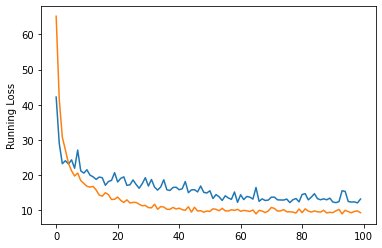

[13.15940514755249, 9.279495883703232]


In [25]:
plot_me([l,l2])